## <font color=blue>Contents<font/>

#########################################################################################################

1. **Jupyter setup <br>**
2. **Data Load <br>**
3. **Exploratory Data Analysis <br>**
    * **Identify Variables and Variable Types and Clean**
    * **Derive Variables**
    * **Identify and Handle Outliers**
    * **Inspect Distributions**
    * **Remove Outlier Rows and Rerun Distribution Plots** <br><br>
4. **Regression Model Builds**

#########################################################################################################

## <font color=blue>Jupyter Setup<font/>

###  Import required libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
import math
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 50)

## <font color=blue>Data Load<font/>

### Load data:

In [3]:
orig_df = pd.read_csv('kc_house_data.csv')

In [4]:
df = orig_df.copy()

### Preview data:

In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## <font color=blue>Exploratory Data Analysis</font>

### Identify variables and variable Types:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


Upon inital inspection:

1. Three variables have null values: **`waterfront`**, **`view`** and **`yr_renovated`**
2. **`date`** looks to be a string variable instead of datetime

###############################################################

### Inspect each variable individually, looking for any further integrity issues

###  <font color=green>id</font>

Would it be possible to use **`id`** as the index column?

In [7]:
len(df['id'].unique())

21420

No, as there are duplicate ids within the column which indicates that the same property has been sold multiple times within the time frame of the dataset.

A follow up question is whether it would be worth creating a derived variable that flags those properties that have been sold multiple times to be used as possible input variable fo rthe regression model?

In [8]:
id_vc = pd.DataFrame(df['id'].value_counts())  # Check how many times properties appear within the dataset
id_vc = id_vc.reset_index()
id_vc.columns

number_of_unique_ids = len(id_vc.loc[id_vc['id'] > 1].sort_values(by = 'id', ascending = False))

print('{}'.format(round((number_of_unique_ids / len(id_vc))*100, 2)) + '% of properties were sold multiple times')

0.82% of properties were sold multiple times


Properties sold multiple times only account for 0.82% of all unique properties within the dataset and therefore there is no real value in deriving a variable to flag 'number of times sold'

### <br><font color=green>date</font>

In [9]:
df['date'].describe()
type(df['date'][0])

df['date'].sort_values(ascending=True).head()

12076    1/10/2015
19359    1/12/2015
2548     1/12/2015
18398    1/12/2015
11086    1/12/2015
Name: date, dtype: object

the **`date`** variable is stored as a str object and needs to be converted to **datetime** format

In [10]:
df['date'] = pd.to_datetime(df['date'])

Verifying the modification has worked:

In [11]:
df['date'].sort_values(ascending=True).head()

7316    2014-05-02
20586   2014-05-02
1040    2014-05-02
20543   2014-05-02
9587    2014-05-02
Name: date, dtype: datetime64[ns]

In [12]:
df['date'].sort_values(ascending=False).head()

16580   2015-05-27
13040   2015-05-24
5632    2015-05-15
12623   2015-05-14
19381   2015-05-14
Name: date, dtype: datetime64[ns]

In [13]:
type(df['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

### <font color=green>price</font>

In [14]:
df['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [15]:
type(df['price'][0])

numpy.float64

**`price`** variable type is fine

### <font color=green>bedrooms</font>

In [16]:
df['bedrooms'].describe()

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

In [17]:
print(type(df['bedrooms'][0]))
df['bedrooms'].value_counts()

<class 'numpy.int64'>


3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

**`bedrooms`** variable is of correct type but there does seem to be some extreme values: 33, 11 and 10

The variable is also clearly a categorical variable.

Outliers will be dealt with later

### <font color=green>bathrooms</font>

In [18]:
df['bathrooms'].describe()

count    21597.000000
mean         2.115826
std          0.768984
min          0.500000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64

In [19]:
print(type(df['bathrooms'][0]))
df['bathrooms'].value_counts()

<class 'numpy.float64'>


2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

**`bathrooms`** variable is of correct type but there could be possible extreme outliers of bathrooms per bedroom > 6

This variable can potentially be considered as a categorical variable

### <font color=green>sqft_living</font>

In [20]:
df['sqft_living'].describe()

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

In [21]:
print(type(df['sqft_living'][0]))
df['sqft_living'].value_counts()

<class 'numpy.int64'>


1300    138
1400    135
1440    133
1660    129
1010    129
       ... 
4970      1
2905      1
2793      1
4810      1
1975      1
Name: sqft_living, Length: 1034, dtype: int64

**`sqft_living`** variable is fine

### <font color=green>sqft_lot</font>

In [22]:
df['sqft_lot'].describe()

count    2.159700e+04
mean     1.509941e+04
std      4.141264e+04
min      5.200000e+02
25%      5.040000e+03
50%      7.618000e+03
75%      1.068500e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

In [23]:
print(type(df['sqft_lot'][0]))
df['sqft_lot'].value_counts()

<class 'numpy.int64'>


5000      358
6000      290
4000      251
7200      220
7500      119
         ... 
1448        1
38884       1
17313       1
35752       1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64

**`sqft_lot`** variable is of correct type but there does seem to be some extreme values: 1,651,359 sq ft.<br>

Outliers will be dealt with later

### <font color=green>floors</font>

In [24]:
df['floors'].describe()

count    21597.000000
mean         1.494096
std          0.539683
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

In [25]:
type(df['floors'][0])
df['floors'].value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

**`floors`** is of correct type

This variable is a categorical variable

### <font color=green>waterfront</font>

In [26]:
df['waterfront'].describe()

count    19221.000000
mean         0.007596
std          0.086825
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: waterfront, dtype: float64

In [27]:
df['waterfront'].isna().sum()

2376

the **`waterfront`** variable has 2,376 missing values

This variable is a categorical variable

In [29]:
print(type(df['waterfront'][0]))

#df['waterfront'] = df['waterfront'].astype('int64')

df['waterfront'].value_counts()

<class 'numpy.float64'>


0.0    19075
1.0      146
Name: waterfront, dtype: int64

the variable is of correct boolean type

the missing will need to be imputed with a placeholder value: **9.0**

In [30]:
df['waterfront'] = df['waterfront'].fillna(9.0)

Verifying the imputation has worked:

In [31]:
df['waterfront'].value_counts()

0.0    19075
9.0     2376
1.0      146
Name: waterfront, dtype: int64

In [33]:
df['waterfront'] = df['waterfront'].astype('int64')
df['waterfront'].value_counts()

0    19075
9     2376
1      146
Name: waterfront, dtype: int64

### <font color=green>view</font>

In [34]:
df['view'].describe()

count    21534.000000
mean         0.233863
std          0.765686
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: view, dtype: float64

In [35]:
df['view'].isna().sum()

63

the **`view`** variable has 63 missing values

In [37]:
type(df['view'][0])

numpy.float64

the variable is of correct numerical type

the missing will need to be imputed with a placeholder value: median of non-null **`view`**

In [38]:
df['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [39]:
view_median = df['view'].loc[df['view'].isna() == False].median()
print(view_median)

0.0


In [40]:
df['view'] = df['view'].fillna(int(view_median))

Verifying the imputation has worked:

In [41]:
df['view'] = df['view'].astype('int64')

df['view'].value_counts()

0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64

In [42]:
df['view'].describe()

count    21597.000000
mean         0.233181
std          0.764673
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: view, dtype: float64

This variable is a categorical variable

### <font color=green>condition</font>

In [43]:
print(df['condition'].describe(),'\n')
print(type(df['condition'][0]))
df['condition'].value_counts()

count    21597.000000
mean         3.409825
std          0.650546
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64 

<class 'numpy.int64'>


3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

**`condition`** is of correct type

This variable is a categorical variable

### <font color=green>grade</font>

In [44]:
print(df['grade'].describe(), '\n')
print(type(df['grade'][0]))
df['grade'].value_counts()

count    21597.000000
mean         7.657915
std          1.173200
min          3.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64 

<class 'numpy.int64'>


7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

**`grade`** is of correct type

This variable is a categorical variable

### <font color=green>sqft_above</font>

In [45]:
print(df['sqft_above'].describe(), '\n')
print(type(df['sqft_above'][0]))
df['sqft_above'].value_counts()

count    21597.000000
mean      1788.596842
std        827.759761
min        370.000000
25%       1190.000000
50%       1560.000000
75%       2210.000000
max       9410.000000
Name: sqft_above, dtype: float64 

<class 'numpy.int64'>


1300    212
1010    210
1200    206
1220    192
1140    184
       ... 
2601      1
440       1
2473      1
2441      1
1975      1
Name: sqft_above, Length: 942, dtype: int64

### <font color=green>sqft_basement</font>

In [47]:
print(df['sqft_basement'].describe(), '\n')
print(type(df['sqft_basement'][0]))
df['sqft_basement'].value_counts()

count     21597
unique      304
top         0.0
freq      12826
Name: sqft_basement, dtype: object 

<class 'str'>


0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
295.0         1
2610.0        1
861.0         1
1930.0        1
946.0         1
Name: sqft_basement, Length: 304, dtype: int64

There is a random '?' value within the **`sqft_basement`** variable and needs to be treated as a missing value but since we want to convert the variable to of numerical type we need to replace the '?' with a numerical missing value placeholder.

First need to check the median value for all values != '?'

In [48]:
sqft_basement_median = df['sqft_basement'].loc[df['sqft_basement'] != '?'].median()
print(sqft_basement_median)

0.0


replace '?' with '0.0':

In [49]:
df['sqft_basement'] = df['sqft_basement'].replace('?',str(sqft_basement_median))

Verify imputation:

In [51]:
df['sqft_basement'].value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
1880.0        1
3500.0        1
1816.0        1
1135.0        1
2600.0        1
Name: sqft_basement, Length: 303, dtype: int64

<br> The **`sqft_basement`** variable is stored as a str needs to be converted into a integer format

In [59]:
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: float(x)).astype('int64')

Verify modification:

In [60]:
print(df['sqft_basement'].describe(), '\n')
print(df['sqft_basement'].isna().sum(), '\n')
df['sqft_basement'].head()

count    21597.000000
mean       285.716581
std        439.819830
min          0.000000
25%          0.000000
50%          0.000000
75%        550.000000
max       4820.000000
Name: sqft_basement, dtype: float64 

0 



0      0
1    400
2      0
3    910
4      0
Name: sqft_basement, dtype: int64

### <font color=green>yr_built</font>

In [61]:
print(df['yr_built'].describe(), '\n')
print(type(df['yr_built'][0]))
df['yr_built'].value_counts()

count    21597.000000
mean      1970.999676
std         29.375234
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64 

<class 'numpy.int64'>


2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

Will be usefule to bin this variable into decades.

which will also make it a categorical variable.

Will be done later on

### <font color=green>yr_renovated</font>

In [62]:
print(df['yr_renovated'].describe(), '\n')
print(type(df['yr_renovated'][0]))
df['yr_renovated'].value_counts()

count    17755.000000
mean        83.636778
std        399.946414
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64 

<class 'numpy.float64'>


0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

* Missing values seem to exist
* a value of 0.0 is assumed to mean not renovated
* Categorical variable

In [63]:
df['yr_renovated'].isna().sum()

3842

3,842 missing values need to be imputed

First need to check whether 2050.0 will be a safe choice for a missing value placeholder:

In [65]:
sorted(df['yr_renovated'].loc[df['yr_renovated'] != 0.0].unique(), reverse = True)

[nan,
 2015.0,
 2014.0,
 2013.0,
 2012.0,
 2011.0,
 2010.0,
 2009.0,
 2008.0,
 2007.0,
 2006.0,
 2005.0,
 2004.0,
 2003.0,
 2002.0,
 2001.0,
 2000.0,
 1999.0,
 1998.0,
 1997.0,
 1996.0,
 1995.0,
 1994.0,
 1993.0,
 1992.0,
 1991.0,
 1990.0,
 1989.0,
 1988.0,
 1987.0,
 1986.0,
 1985.0,
 1984.0,
 1983.0,
 1982.0,
 1981.0,
 1980.0,
 1979.0,
 1978.0,
 1977.0,
 1976.0,
 1975.0,
 1974.0,
 1973.0,
 1972.0,
 1971.0,
 1970.0,
 1969.0,
 1968.0,
 1967.0,
 1965.0,
 1964.0,
 1963.0,
 1962.0,
 1960.0,
 1959.0,
 1958.0,
 1957.0,
 1956.0,
 1955.0,
 1954.0,
 1953.0,
 1951.0,
 1950.0,
 1948.0,
 1946.0,
 1945.0,
 1944.0,
 1940.0,
 1934.0]

2050 will be a safe choice to represent missing values:

In [66]:
df['yr_renovated'] = df['yr_renovated'].fillna(2050.0)
df['yr_renovated'] = df['yr_renovated'].astype('int64')
# verify imputation
df['yr_renovated'].value_counts()

0       17011
2050     3842
2014       73
2003       31
2013       31
        ...  
1959        1
1953        1
1951        1
1944        1
1976        1
Name: yr_renovated, Length: 71, dtype: int64

### <font color=green>zipcode</font>

In [67]:
print(df['zipcode'].describe(), '\n')
print(df['zipcode'].head(), '\n')
print(type(df['zipcode'][0]), '\n')
print(df['zipcode'].value_counts(), '\n')
df['zipcode'].isna().sum()

count    21597.000000
mean     98077.951845
std         53.513072
min      98001.000000
25%      98033.000000
50%      98065.000000
75%      98118.000000
max      98199.000000
Name: zipcode, dtype: float64 

0    98178
1    98125
2    98028
3    98136
4    98074
Name: zipcode, dtype: int64 

<class 'numpy.int64'> 

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64 



0

**`zipcode`** is of correct type

#### <font color=green>lat</font>

In [68]:
print(df['lat'].describe(), '\n')
print(df['lat'].head(), '\n')
print(type(df['lat'][0]))

count    21597.000000
mean        47.560093
std          0.138552
min         47.155900
25%         47.471100
50%         47.571800
75%         47.678000
max         47.777600
Name: lat, dtype: float64 

0    47.5112
1    47.7210
2    47.7379
3    47.5208
4    47.6168
Name: lat, dtype: float64 

<class 'numpy.float64'>


**`lat`** is of correct type

### <font color=green>long</font>

In [69]:
print(df['long'].describe(), '\n')
print(df['long'].head(), '\n')
print(type(df['long'][0]))

count    21597.000000
mean      -122.213982
std          0.140724
min       -122.519000
25%       -122.328000
50%       -122.231000
75%       -122.125000
max       -121.315000
Name: long, dtype: float64 

0   -122.257
1   -122.319
2   -122.233
3   -122.393
4   -122.045
Name: long, dtype: float64 

<class 'numpy.float64'>


**`long`** is of correct type

### <font color=green>sqft_living15</font>

In [70]:
print(df['sqft_living15'].describe(), '\n')
print(df['sqft_living15'].head(), '\n')
print(type(df['sqft_living15'][0]), '\n')
df['sqft_living15'].value_counts()

count    21597.000000
mean      1986.620318
std        685.230472
min        399.000000
25%       1490.000000
50%       1840.000000
75%       2360.000000
max       6210.000000
Name: sqft_living15, dtype: float64 

0    1340
1    1690
2    2720
3    1360
4    1800
Name: sqft_living15, dtype: int64 

<class 'numpy.int64'> 



1540    197
1440    195
1560    192
1500    180
1460    169
       ... 
4890      1
2873      1
952       1
3193      1
2049      1
Name: sqft_living15, Length: 777, dtype: int64

### <font color=green>sqft_lot15</font>

In [71]:
print(df['sqft_lot15'].describe(), '\n')
print(df['sqft_lot15'].head(), '\n')
print(type(df['sqft_lot15'][0]), '\n')
df['sqft_lot15'].value_counts()

count     21597.000000
mean      12758.283512
std       27274.441950
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10083.000000
max      871200.000000
Name: sqft_lot15, dtype: float64 

0    5650
1    7639
2    8062
3    5000
4    7503
Name: sqft_lot15, dtype: int64 

<class 'numpy.int64'> 



5000      427
4000      356
6000      288
7200      210
4800      145
         ... 
11036       1
8989        1
871200      1
809         1
6147        1
Name: sqft_lot15, Length: 8682, dtype: int64

This is the original structure of the dataframe:

<img src="orig_df_info.png" width = "400">

and this is the new structure after cleaning process cleaning:

##### <font color=red>Cleaned Dataset Formats</font>

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null int64
view             21597 non-null int64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(15)
memory usage: 3.5 MB


### Derive Variables

#### `day_of_week`, `month`, `quarter` derived from `date`

It would be useful to explor whether the time of year or week has any impact on the price of a property. THerefore the day, month and quarter will need to be extracted from the **`date`** column

In [73]:
#   Useful to extract the day, month and quarter from the date variable:

df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


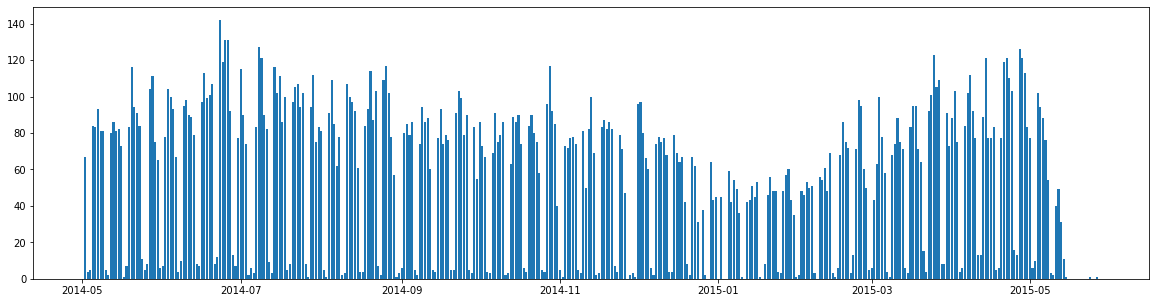

In [74]:
fig = plt.figure(figsize=(20,5))
plt.bar(df['date'].value_counts().index, df['date'].value_counts());

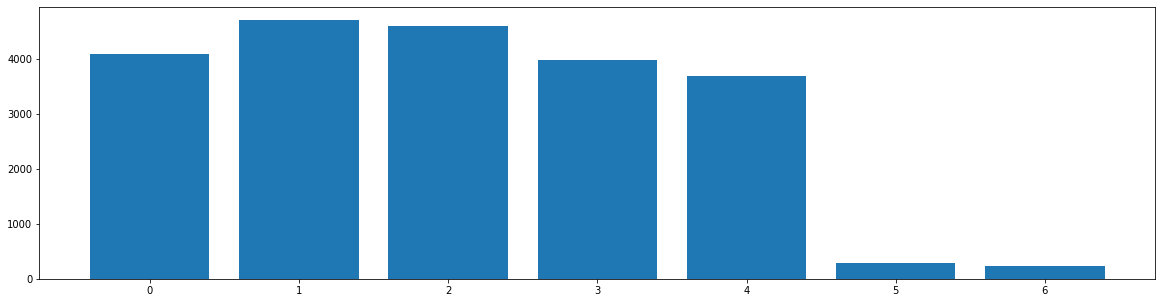

In [75]:
fig = plt.figure(figsize=(20,5))
plt.bar(df['day_of_week'].value_counts().index, df['day_of_week'].value_counts());

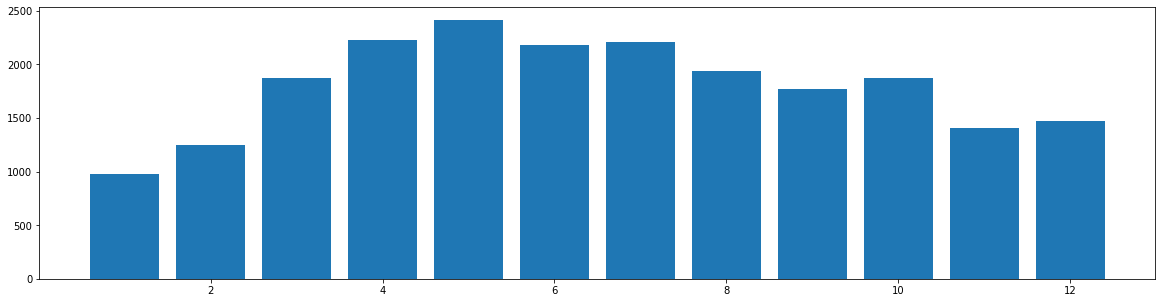

In [76]:
fig = plt.figure(figsize=(20,5))
plt.bar(df['month'].value_counts().index, df['month'].value_counts());

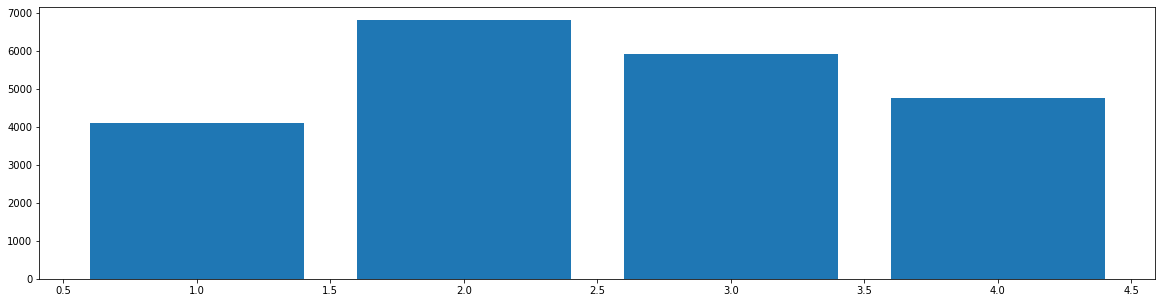

In [77]:
fig = plt.figure(figsize=(20,5))
plt.bar(df['quarter'].value_counts().index, df['quarter'].value_counts());

#### `distance_from_town_centre` derived from `long` and `lat`

Using a fixed longitude and latitude coordinates of [-122.3341, 47.6106] to represent the city centre of Seattle. We will derive a new variable that calculates the distance from the property to the city centre.

In [78]:
from math import sin, cos, sqrt, atan2, radians

In [79]:

def distance_calc(long_lat, city_centre_long_lat = [-122.3341, 47.6106]):
    
    # approximate radius of earth in km
    R = 6373.0
    city_centre_lon = radians(city_centre_long_lat[0])
    city_centre_lat = radians(city_centre_long_lat[1])
    
    addres_lon = radians(float(long_lat.split(',')[0]))
    address_lat = radians(float(long_lat.split(',')[1]))

    dlon = city_centre_lon - addres_lon
    dlat = city_centre_lat - address_lat

    a = sin(dlat / 2)**2 + cos(city_centre_lat) * cos(address_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    
    return distance

In [80]:
df['long_lat_coords'] = df["long"].map(str) + "," + df["lat"].map(str)

In [81]:
df['dist_from_city_centre'] = df['long_lat_coords'].apply(lambda x: distance_calc(x))

In [82]:
df.loc[:,['zipcode','long', 'lat', 'dist_from_city_centre']].head()

,zipcode,long,lat,dist_from_city_centre
0,98178,-122.257,47.5112,12.479186
1,98125,-122.319,47.7210,12.331758
2,98028,-122.233,47.7379,16.057023
3,98136,-122.393,47.5208,10.922917
4,98074,-122.045,47.6168,21.688510


In [83]:
df = df.loc[:,df.columns != 'long_lat_coords'] # Drop this column as it is not needed for our analysis

#### `livingsqft_lotsqft_ratio` derived from `sqft_living` and `sqft_lot`

It has been noted that there are instances where the size of the living space (**`sqft_living`**) is considerably smaller than the size of the lot **`sqft_lot`**. So it will be useful to create a metric that measures the ratio of the living to lot size.

In [84]:
df['livingsqft_lotsqft_ratio'] = df['sqft_living']/df['sqft_lot']

In [85]:
df.loc[:, ['sqft_living', 'sqft_lot', 'livingsqft_lotsqft_ratio']].head()

,sqft_living,sqft_lot,livingsqft_lotsqft_ratio
0,1180,5650,0.208850
1,2570,7242,0.354874
2,770,10000,0.077000
3,1960,5000,0.392000
4,1680,8080,0.207921


#### `yrs_since_renovation` derived from `yr_renovated`

Create a measure of **`yr_renovated`** that is a standardised measure regardless of the year in which the property was sold.

In [86]:
def roundown(x):
    return int(math.floor(x / 10.0)) * 10

def yrs_since_renov(row):
    if (row['yr_renovated'] not in (0, 2050)) and (row['date'].year > row['yr_renovated']):
        return roundown(row['date'].year - row['yr_renovated'])
    elif row['yr_renovated'] == 2050:
        return -2
    else:
        return -1
    
df['yrs_since_renovation'] = df.apply(yrs_since_renov, axis=1)

In [87]:
print(df['yrs_since_renovation'].value_counts())

df.head()

-1     17085
-2      3842
 10      186
 0       180
 20      153
 30       73
 40       37
 50       28
 60        8
 70        4
 80        1
Name: yrs_since_renovation, dtype: int64


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,day_of_week,month,quarter,dist_from_city_centre,livingsqft_lotsqft_ratio,yrs_since_renovation
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,9,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0,10,4,12.479186,0.208850,-1
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,1,12,4,12.331758,0.354874,20
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,2050,98028,47.7379,-122.233,2720,8062,2,2,1,16.057023,0.077000,-2
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,1,12,4,10.922917,0.392000,-1
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2,2,1,21.688510,0.207921,-1


#### `decade_built` derived from `yr_built`

Will be useful to bin the **`yr_built`** variable for exploration purposes

In [88]:
df['decade_built'] = df['yr_built'].apply(lambda x: roundown(x))

In [89]:
df['decade_built'].value_counts()

2000    3515
1960    2658
1950    2450
1970    2285
1980    2281
1990    2232
1940    1763
2010    1241
1920    1192
1910     805
1900     645
1930     530
Name: decade_built, dtype: int64

#### Create dummy alternatives of categorical variables

Many of the independent variables are categorical by nature and so it is required to convert the to dummy vasriables using the one-hot encoding method

In [90]:
df.loc[:,['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'decade_built', 'yrs_since_renovation']] = df.loc[:,['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'decade_built', 'yrs_since_renovation']].astype('int64')

In [91]:
cat_var_dict = {'empty': None}

for i in ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'decade_built', 'yrs_since_renovation']:
  
    cat_var_dict[str(i)+'_dummies'] = pd.get_dummies(df[str(i)], prefix='d_' + str(i)[:5], drop_first=True)
    


In [92]:
list(cat_var_dict.keys())[1:]

['bedrooms_dummies',
 'bathrooms_dummies',
 'floors_dummies',
 'waterfront_dummies',
 'view_dummies',
 'condition_dummies',
 'grade_dummies',
 'decade_built_dummies',
 'yrs_since_renovation_dummies']

In [93]:
df = pd.concat([df, cat_var_dict['bedrooms_dummies'], cat_var_dict['bathrooms_dummies'], cat_var_dict['floors_dummies'], cat_var_dict['waterfront_dummies'], cat_var_dict['view_dummies'], cat_var_dict['condition_dummies'],
             cat_var_dict['grade_dummies'], cat_var_dict['decade_built_dummies'], cat_var_dict['yrs_since_renovation_dummies']], axis=1)

In [94]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,day_of_week,month,quarter,dist_from_city_centre,...,d_grade_10,d_grade_11,d_grade_12,d_grade_13,d_decad_1910,d_decad_1920,d_decad_1930,d_decad_1940,d_decad_1950,d_decad_1960,d_decad_1970,d_decad_1980,d_decad_1990,d_decad_2000,d_decad_2010,d_yrs_s_-1,d_yrs_s_0,d_yrs_s_10,d_yrs_s_20,d_yrs_s_30,d_yrs_s_40,d_yrs_s_50,d_yrs_s_60,d_yrs_s_70,d_yrs_s_80
0,7129300520,2014-10-13,221900.0,3,1,1180,5650,1,9,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0,10,4,12.479186,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,6414100192,2014-12-09,538000.0,3,2,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,1,12,4,12.331758,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,5631500400,2015-02-25,180000.0,2,1,770,10000,1,0,0,3,6,770,0,1933,2050,98028,47.7379,-122.233,2720,8062,2,2,1,16.057023,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2487200875,2014-12-09,604000.0,4,3,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,1,12,4,10.922917,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1954400510,2015-02-18,510000.0,3,2,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2,2,1,21.688510,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


### Identify and Handle Outliers

In [95]:
list(df.columns)

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'day_of_week',
 'month',
 'quarter',
 'dist_from_city_centre',
 'livingsqft_lotsqft_ratio',
 'yrs_since_renovation',
 'decade_built',
 'd_bedro_2',
 'd_bedro_3',
 'd_bedro_4',
 'd_bedro_5',
 'd_bedro_6',
 'd_bedro_7',
 'd_bedro_8',
 'd_bedro_9',
 'd_bedro_10',
 'd_bedro_11',
 'd_bedro_33',
 'd_bathr_1',
 'd_bathr_2',
 'd_bathr_3',
 'd_bathr_4',
 'd_bathr_5',
 'd_bathr_6',
 'd_bathr_7',
 'd_bathr_8',
 'd_floor_2',
 'd_floor_3',
 'd_water_1',
 'd_water_9',
 'd_view_1',
 'd_view_2',
 'd_view_3',
 'd_view_4',
 'd_condi_2',
 'd_condi_3',
 'd_condi_4',
 'd_condi_5',
 'd_grade_4',
 'd_grade_5',
 'd_grade_6',
 'd_grade_7',
 'd_grade_8',
 'd_grade_9',
 'd_grade_10',
 'd_grade_11',
 'd_grade_12',
 'd_grade_13',
 'd_decad_1910',
 'd_d

In [96]:
df_no_dummies = df.loc[:,['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'month',
 'quarter',
 'dist_from_city_centre',
 'livingsqft_lotsqft_ratio',
 'yrs_since_renovation',
 'decade_built']]

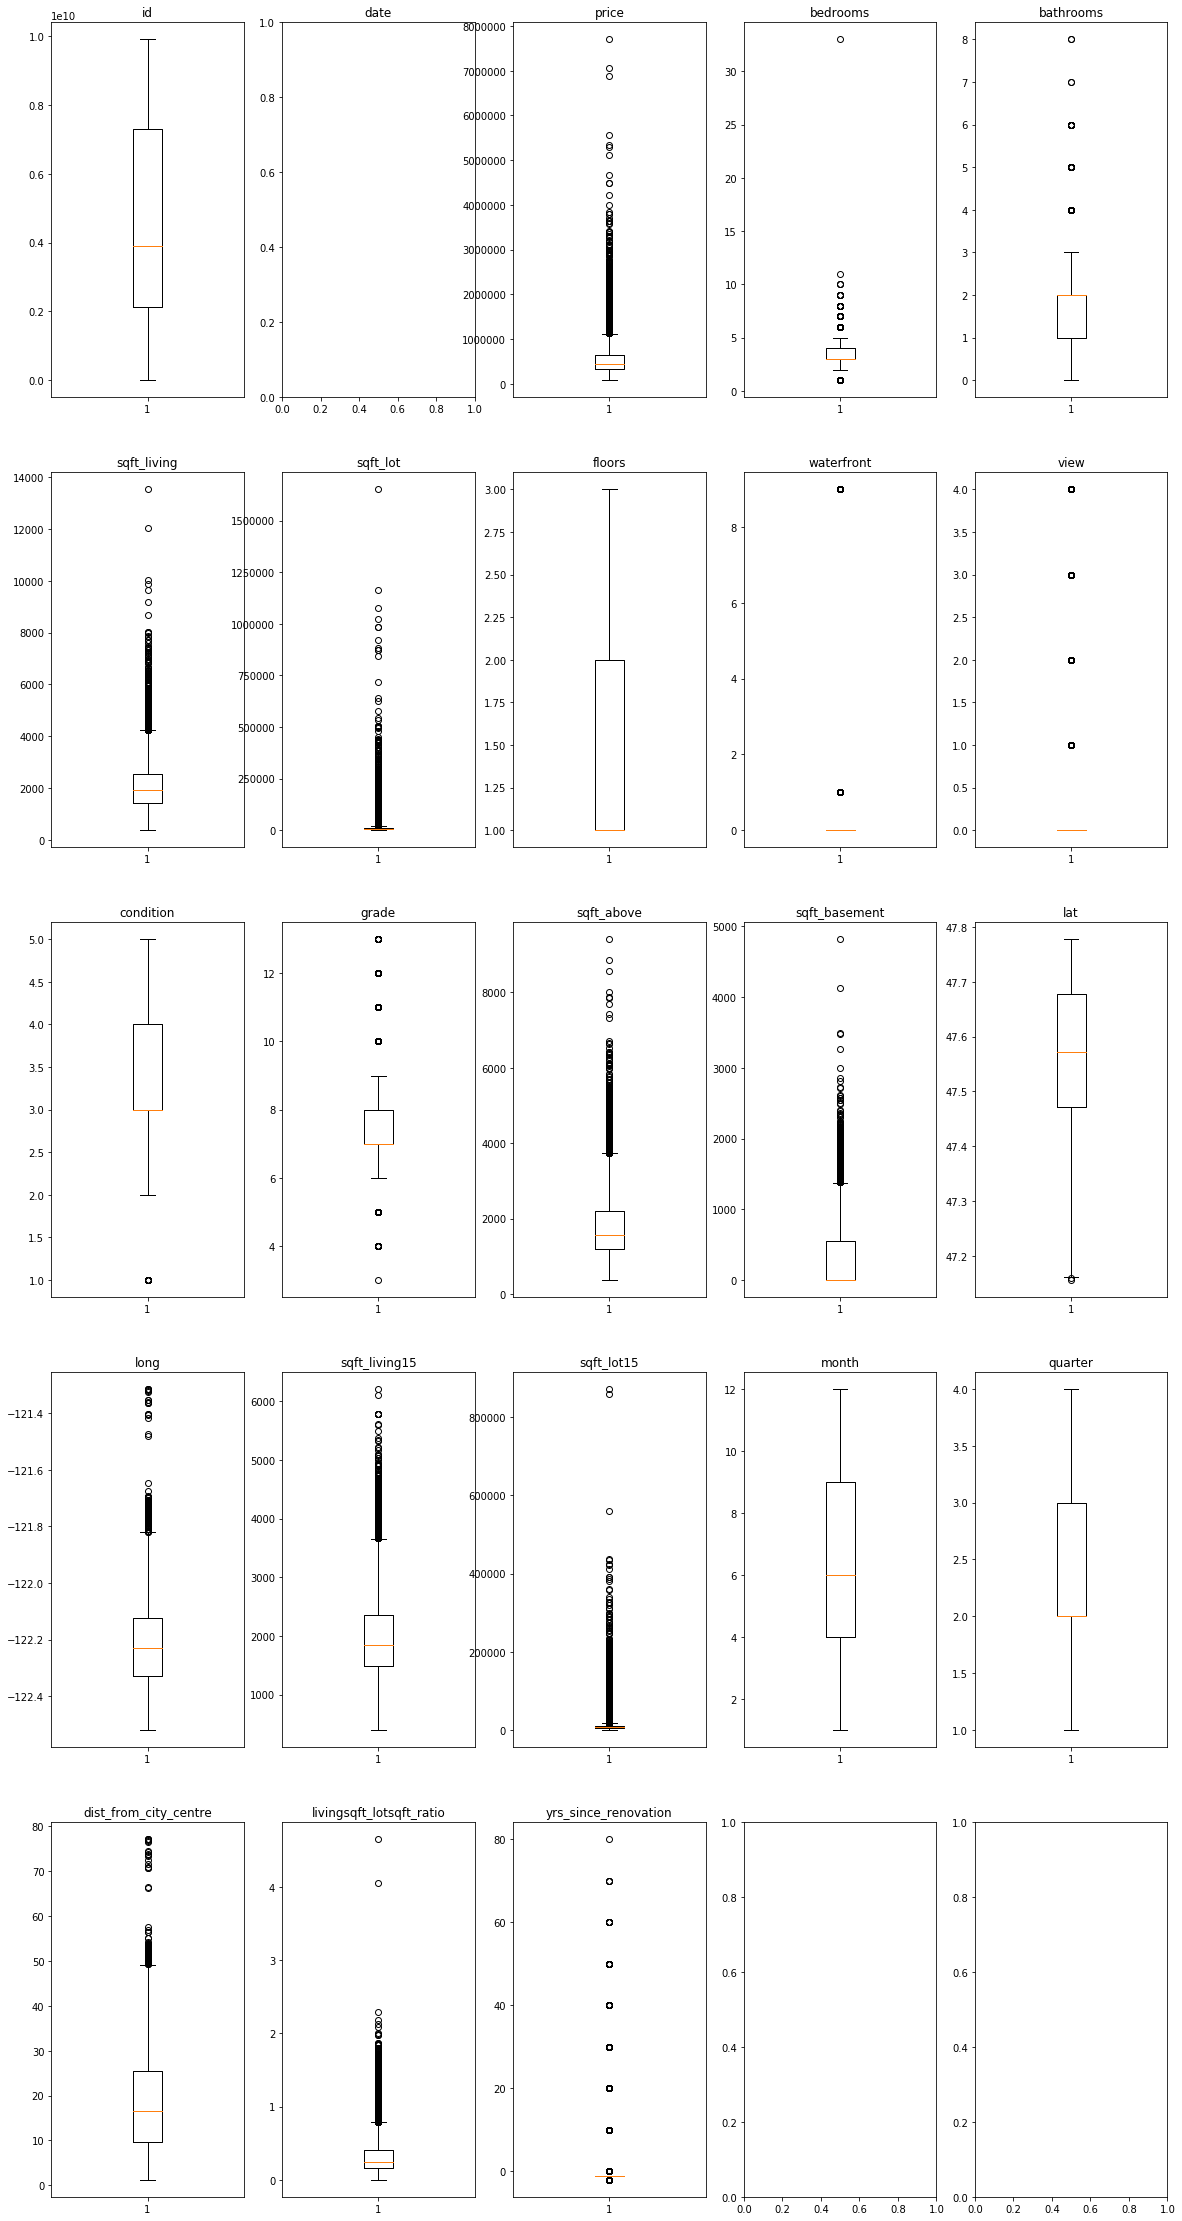

In [97]:
fig2, axes2 = plt.subplots(5, 5, figsize = (20,40))
axes2.shape




for n in range(1,24):
    
    i = df_no_dummies.dtypes.index[n-1]
    
    row = (n-1)//5
    col = (n-1)%5
    
    if str(type(df_no_dummies[str(i)][0])) in ["<class 'numpy.float64'>", "<class 'numpy.int64'>"]:
        ax = axes2[row][col]
        ax.boxplot(df[str(i)])
        ax.set_title('{}'.format(i))
    else:   
        ax = axes2[row][col]
        ax.set_title('{}'.format(i))
        continue

Initial observations:

* **`bedrooms`**, **`sqft_lot`**, **`sqft_basement`**, **`sqft_lot15`** have clear extreme outliers which require removing/imputation
* **`bathrooms`** may have possible outliers of >6
* boxplots for **`view`**, **`yr_renovated`** have been distorted due to the previous step of imputing values for the missing observations with 9999.0. The box plot will have to be re-run without these imputed observations


/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


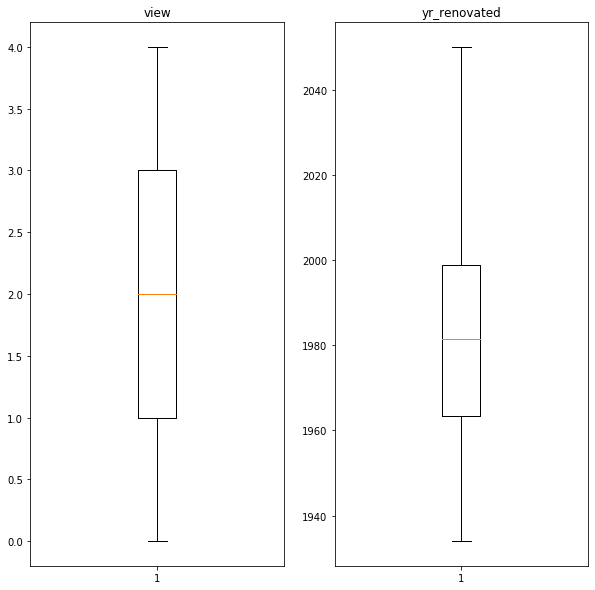

In [98]:
fig2, axes2 = plt.subplots(1, 2, figsize = (10,10))
axes2.shape

col = (-1)
for n in range(1,27):
    
    i = df.dtypes.index[n-1]
    
    row = 1
    
    
    if i in ['view']:
        
        col += 1
        a = [x for x in df[str(i)].value_counts().index if x != 9999.0]
        b = [df[str(i)].value_counts().ix[x] for x in df[str(i)].value_counts().index if x != 9999.0]
        

        ax = axes2[col]
        ax.boxplot(a)
        ax.set_title('{}'.format(i))
        
    elif i in ['yr_renovated']:
        
        col += 1
        a = [x for x in df[str(i)].value_counts().index if (x != 9999.0) and (x != 0.0)]
        b = [df[str(i)].value_counts().ix[x] for x in df[str(i)].value_counts().index if x != 9999.0]
        
       
        ax = axes2[col]
        ax.boxplot(a)
        ax.set_title('{}'.format(i));
    else:   
        continue

### Inspect Distributions

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


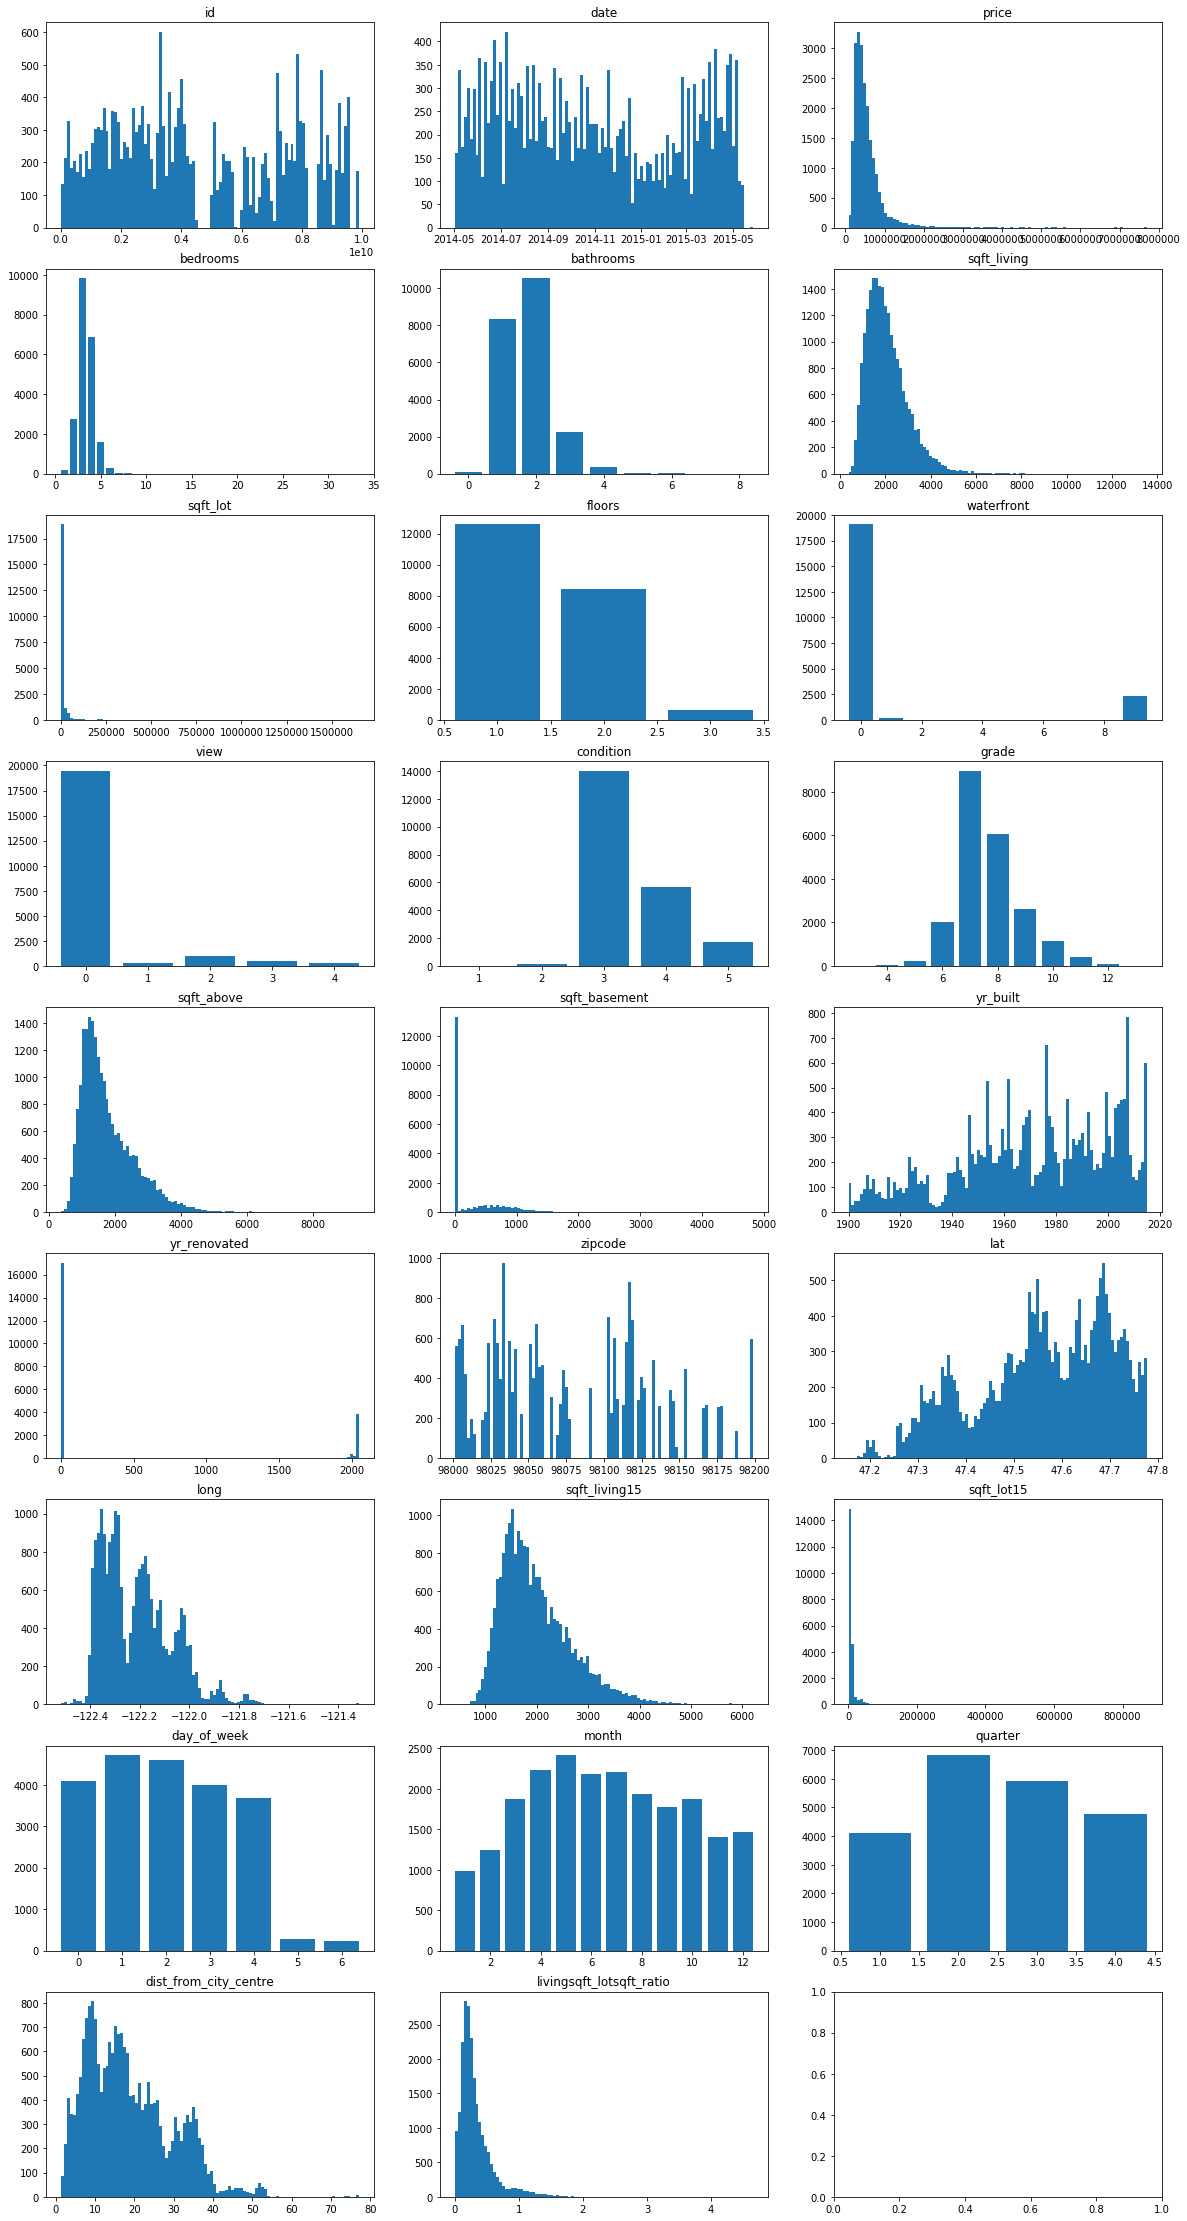

In [99]:
fig, axes = plt.subplots(9, 3, figsize = (20,40))
axes.shape


for n in range(1,27):
    
    i = df.dtypes.index[n-1]
    
    row = (n-1)//3
    col = (n-1)%3
    
    if len(df[str(i)].unique()) > 50:
        #continue
        ax = axes[row][col]
        ax.set_title('{}'.format(i))
        ax.hist(df[str(i)], bins = 100)
        continue
    
    a = [x for x in df[str(i)].value_counts().index if x != 9999.0]
    b = [df[str(i)].value_counts().ix[x] for x in df[str(i)].value_counts().index if x != 9999.0]
        
    ax = axes[row][col]
    ax.bar(a, b)
    ax.set_title('{}'.format(i))  

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


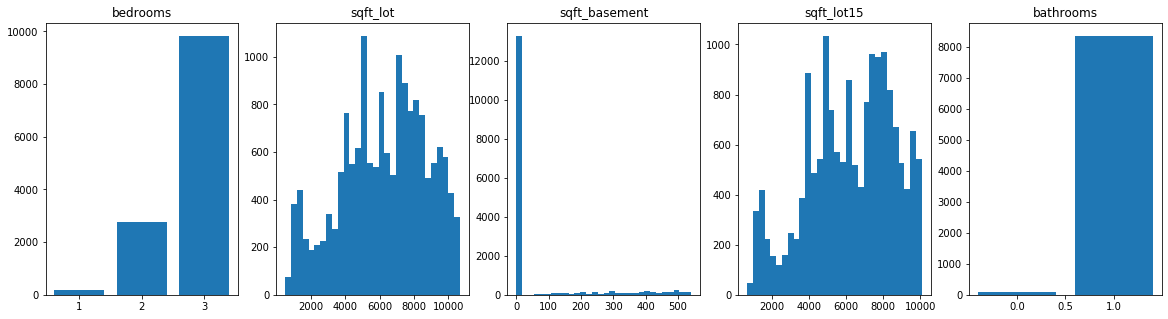

In [100]:
outl_vars = ['bedrooms', 'sqft_lot', 'sqft_basement', 'sqft_lot15', 'bathrooms']
def remove_outliers_and_plot_bars(list_of_vars):
    
    fig2, axes2 = plt.subplots(1, 5, figsize = (20,5))

    col = (-1)
    
    for i in list_of_vars:
        
            
        col += 1
    
        pcntle = np.percentile(df[str(i)], 75)
        
        
        
        if len(df[str(i)].unique()) > 50:
            ax = axes2[col]
            ax.hist(df[str(i)].loc[df[str(i)] < pcntle], bins = 30)
            ax.set_title('{}'.format(i))
    
            continue
    
        else:

            a = [x for x in df[str(i)].value_counts().index if x < pcntle]
            b = [df[str(i)].value_counts().ix[x] for x in df[str(i)].value_counts().index if x < pcntle]
            
            ax = axes2[col]
            ax.bar(a, b)
            ax.set_title('{}'.format(i))
    
    col = (-1)
        
remove_outliers_and_plot_bars(outl_vars)

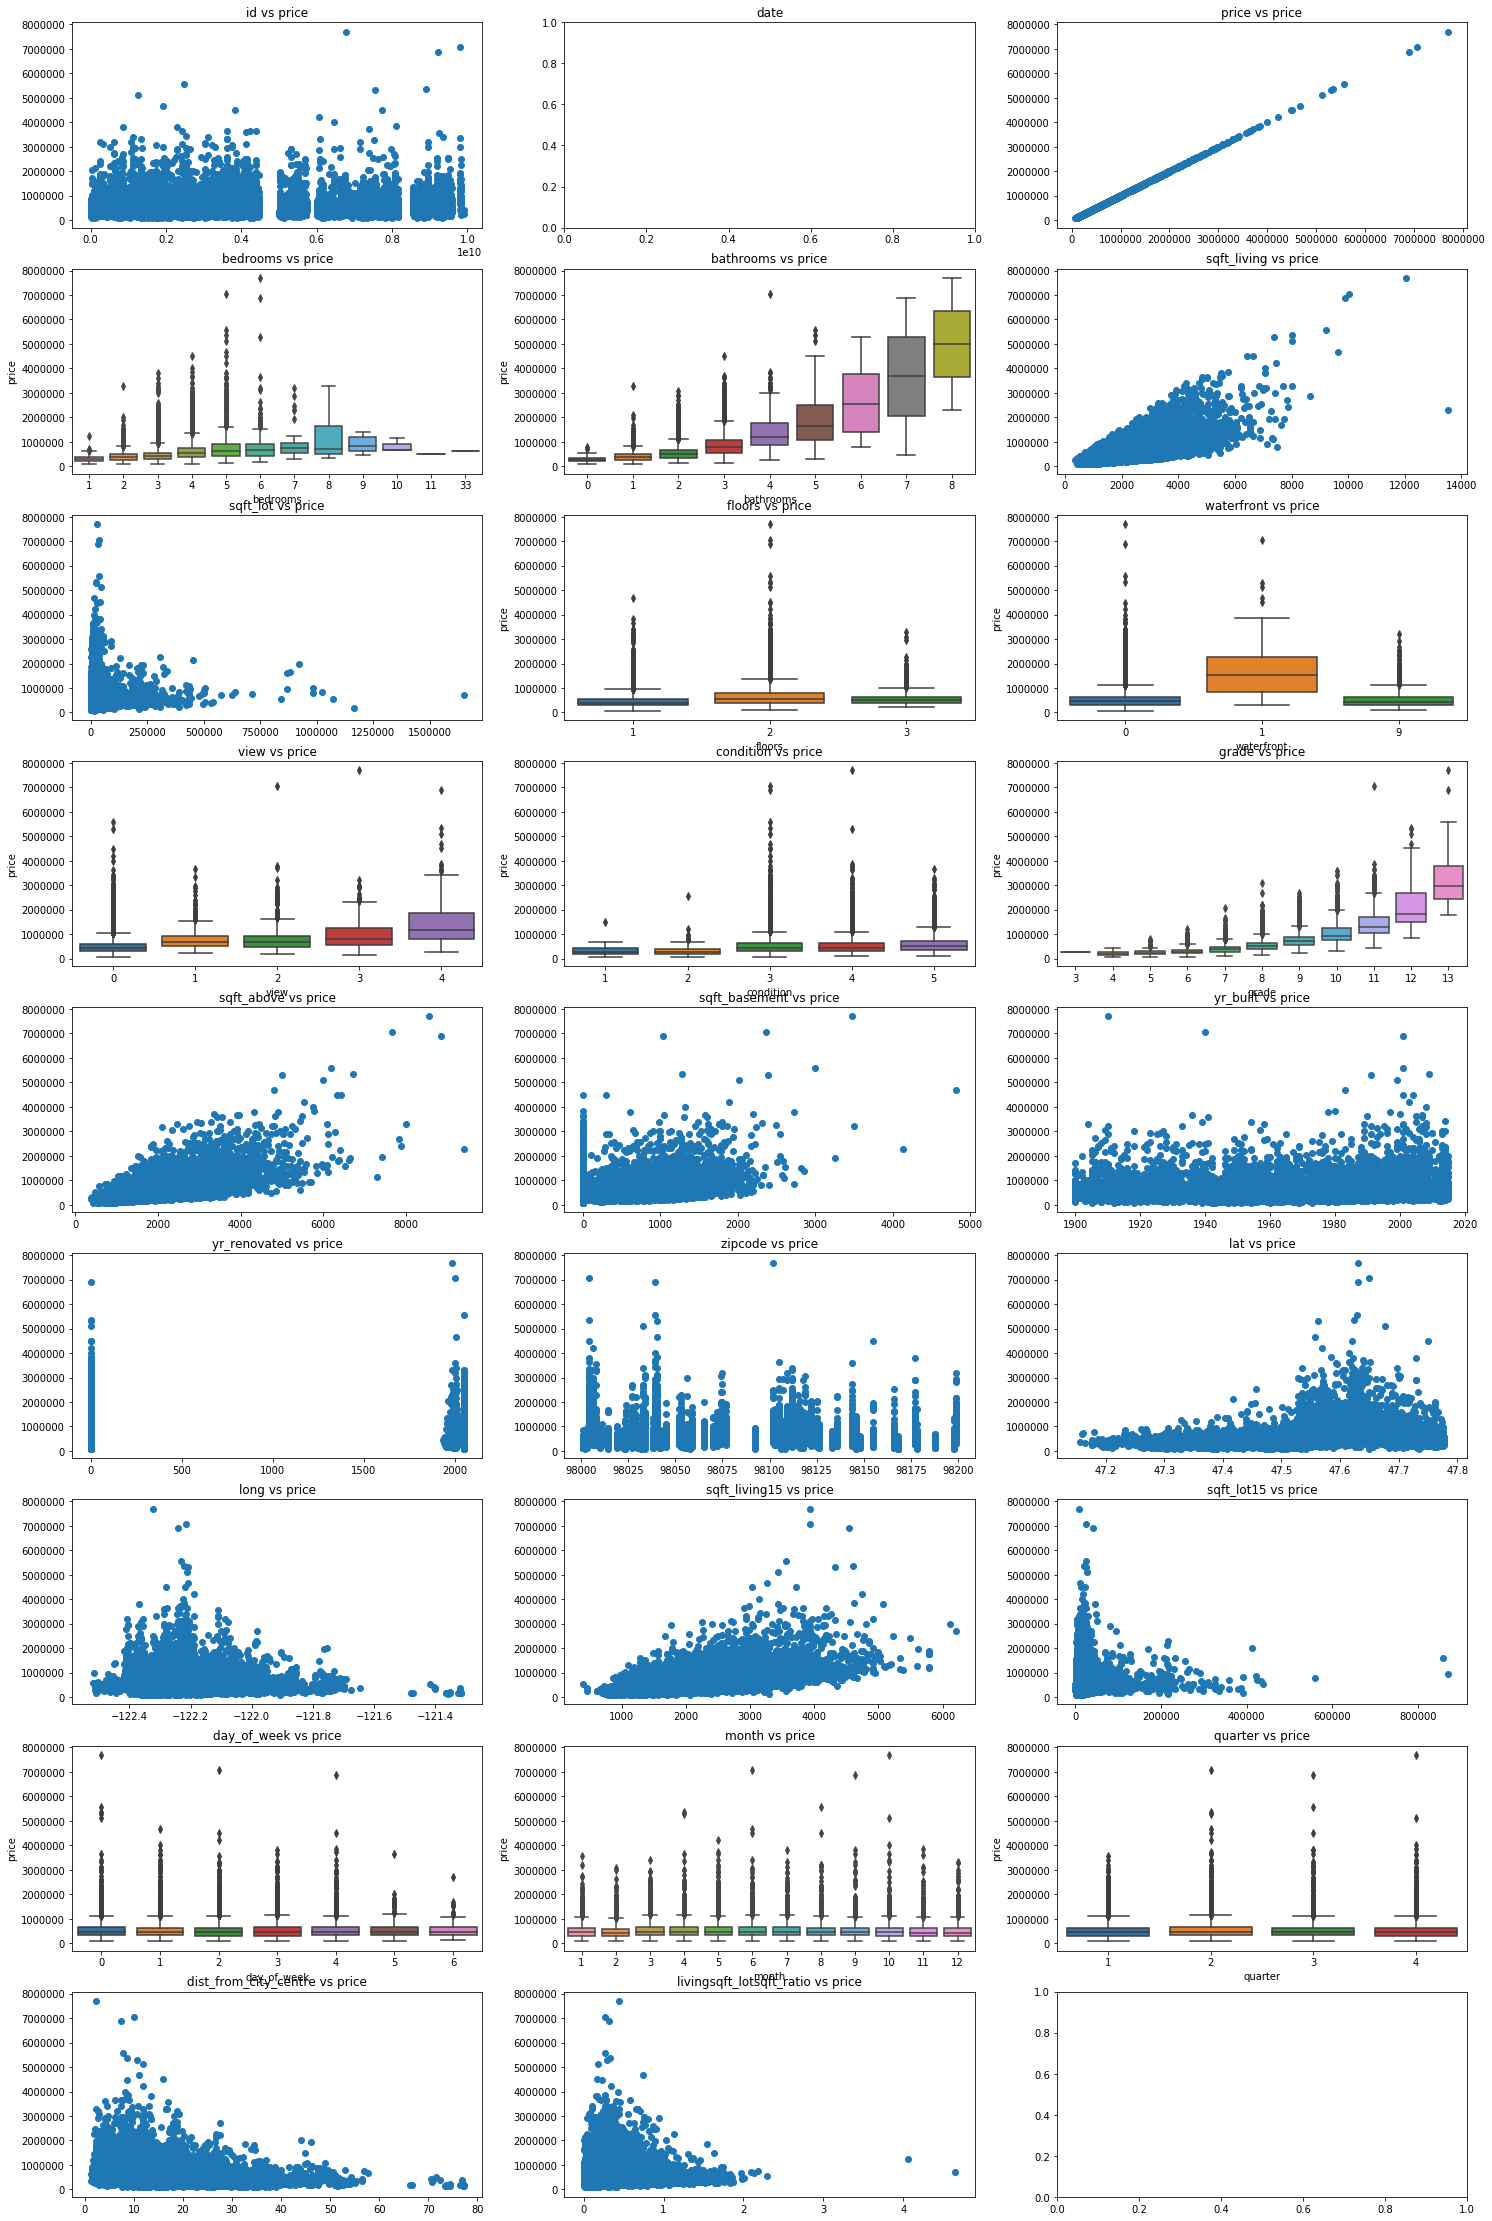

In [101]:
fig3, axes3 = plt.subplots(9, 3, figsize = (25,40))
axes3.shape


for n in range(1,27):
    
    i = df.dtypes.index[n-1]
    
    row = (n-1)//3
    col = (n-1)%3
    
    if str(type(df[str(i)][0])) in ["<class 'numpy.float64'>", "<class 'numpy.int64'>"]:
        
        if (len(df[str(i)].unique()) > 12) and (str(i) not in ['bathrooms']):
        
            ax = axes3[row][col]
            ax.scatter(df[str(i)], df['price'])
            ax.set_title('{}'.format(i) + ' vs price')
            
        
        else:
            ax = axes3[row][col]
            sns.boxplot(str(i), 'price', data=df, ax=ax)
            ax.set_title('{}'.format(i) + ' vs price')
    else:   
        ax = axes3[row][col]
        ax.set_title('{}'.format(i))
        continue

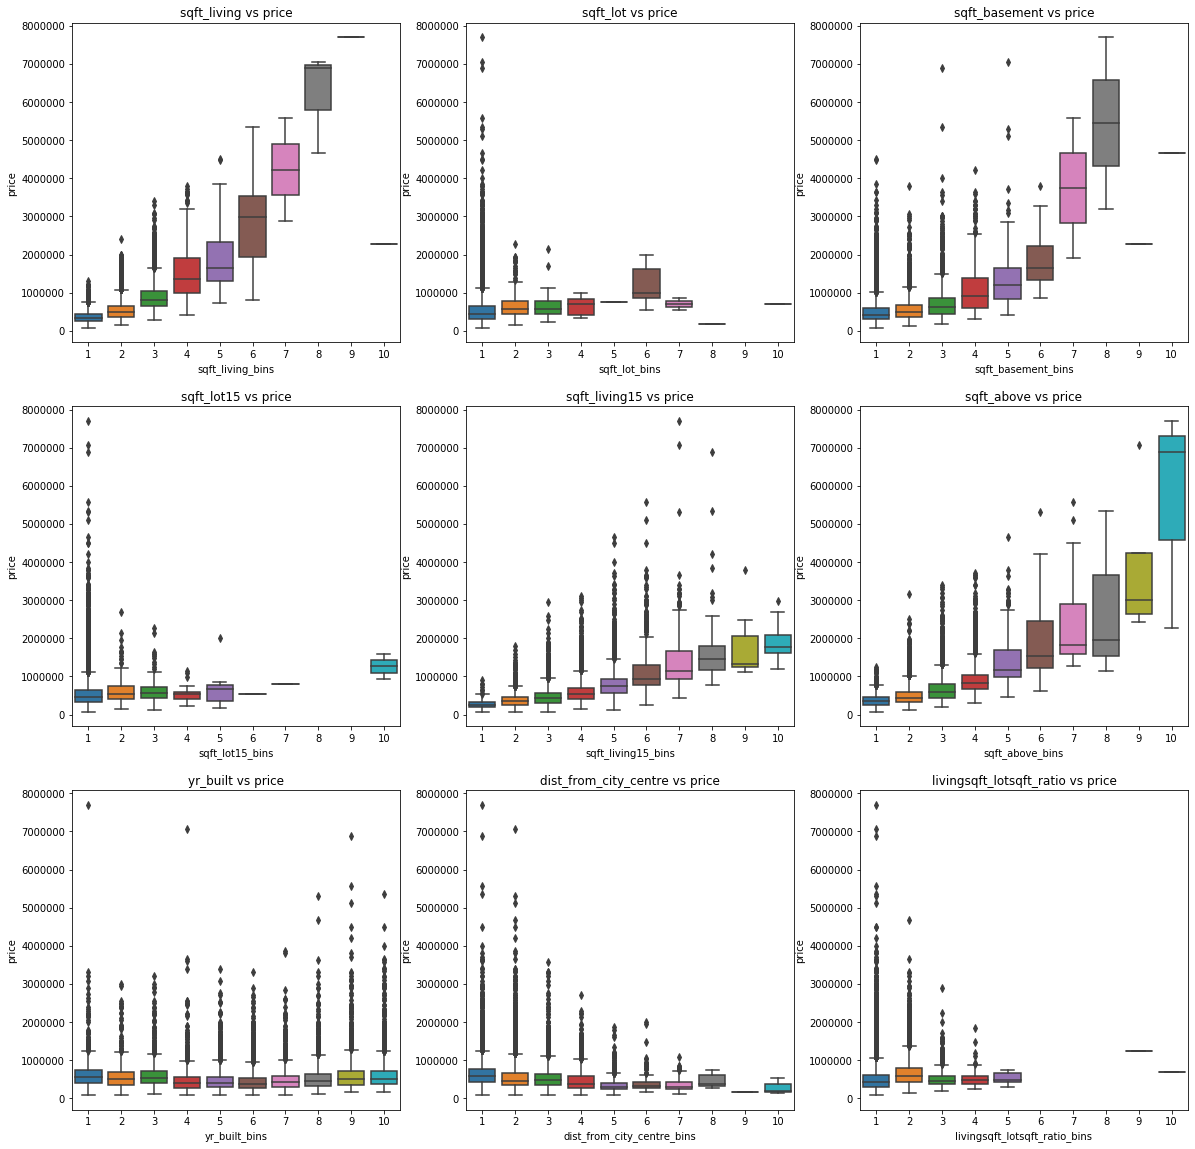

In [102]:
outl_vars = ['sqft_living', 'sqft_lot', 'sqft_basement', 'sqft_lot15', 'sqft_living15'
             , 'sqft_above', 'yr_built', 'dist_from_city_centre'
             ,'livingsqft_lotsqft_ratio']


for i in outl_vars:
    
    df[(str(i) + '_bins')] = pd.cut(df[str(i)], 10, labels = list(range(1,11)))
    
    


def remove_outliers_and_plot_grouped_boxes(list_of_vars):
    
    fig2, axes2 = plt.subplots(3, 3, figsize = (20,20))

   
    n = (-1)
    for i in list_of_vars:
        
        n += 1
        
        row = (n)//3
        col = (n)%3
        
        ax = axes2[row][col]
        sns.boxplot((str(i) + '_bins'), 'price', data=df, ax=ax)
        ax.set_title('{}'.format(str(i)) + ' vs price')
    

    n = (-1)  
        
remove_outliers_and_plot_grouped_boxes(outl_vars)

Text(0.5, 1.0, 'yr_renovated vs price')

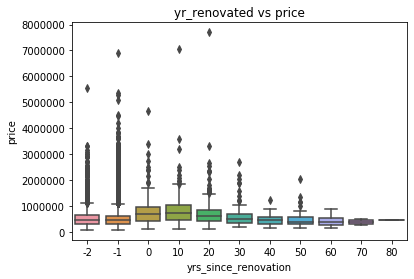

In [103]:
sns.boxplot('yrs_since_renovation', 'price', data=df).set_title('yr_renovated vs price')

**Initial observations:**

The following variables show some sort of correlation upon price (observed either in the scatter plots or the grouped box-plots):

* **`sqft_living`**
* **`sqft_lot`**
* **`bedrooms`**
* **`bathrooms`**
* **`floors`**
* **`condition`**
* **`sqft_living15`**
* **`grade`**
* **`dist_from_city_centre`**
* **`livingsqft_lotsqft_ratio`**
* **`yrs_since_renovation`**

just to confirm by calculating Pearson's Correlation for the above variables against **`price`**

In [104]:
from scipy.stats import pearsonr


for i in ['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'condition', 'sqft_living15', 'grade', 'dist_from_city_centre', 'livingsqft_lotsqft_ratio', 'yrs_since_renovation']:

    print('{} :'.format(i) + str(round(pearsonr(df[i], df['price'])[0], 2)))

sqft_living :0.7
sqft_lot :0.09
bedrooms :0.31
bathrooms :0.51
floors :0.24
condition :0.04
sqft_living15 :0.59
grade :0.67
dist_from_city_centre :-0.29
livingsqft_lotsqft_ratio :0.12
yrs_since_renovation :0.05


Based on Pearson's correlation the following variables show the strongest correlation with price:

* **`sqft_living`**   => 0.7
* **`bathrooms`**     => 0.51
* **`sqft_living15`** => 0.59
* **`grade`**         => 0.67

### Remove Outliers

The next steps will remove outliers from the dataset.

In [105]:
df = df.loc[df['bedrooms'] < 33] # Obvious outlier from the scatter plot

In [106]:
df = df.loc[df['sqft_lot'] < 1651359] # Obvious outlier from the scatter plot

In [107]:
df_without_outliers = pd.DataFrame(None)

# below loop will loop through all the variables that have previously been identified as having upper outliers and will
# flag the observations to which the outliers belong in the dataset (only upper outliers)

for i in ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'
          ,'floors', 'sqft_above','sqft_basement'
          ,'sqft_living15', 'sqft_lot15']:
    
    data_mean, data_std = np.mean(df[str(i)]), np.std(df[str(i)])
    # identify outliers
    cut_off = data_std * 3
    upper = data_mean + cut_off
    df_without_outliers[str(i) + '_outlier_flag'] = (df[str(i)] >= upper)
        
        
df_without_outliers = df_without_outliers.replace(True,np.nan).dropna(axis = 0, how = 'any')

In [111]:
df_without_outliers

,price_outlier_flag,bedrooms_outlier_flag,bathrooms_outlier_flag,sqft_living_outlier_flag,sqft_lot_outlier_flag,floors_outlier_flag,sqft_above_outlier_flag,sqft_basement_outlier_flag,sqft_living15_outlier_flag,sqft_lot15_outlier_flag
0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
21592,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0
21593,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0
21594,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0
21595,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0


In [112]:
indexes_to_keep = df_without_outliers.index

print(indexes_to_keep)
len(indexes_to_keep)


# highlight observations that do not have any outliers across any columns

Int64Index([    0,     1,     2,     3,     4,     6,     7,     8,     9,
               11,
            ...
            21587, 21588, 21589, 21590, 21591, 21592, 21593, 21594, 21595,
            21596],
           dtype='int64', length=20156)


20156

In [113]:
df_without_outlier_rows = df.ix[indexes_to_keep]

len(df_without_outlier_rows)

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


20156

In [114]:
df_without_outlier_rows.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'day_of_week', 'month',
       'quarter', 'dist_from_city_centre', 'livingsqft_lotsqft_ratio',
       'yrs_since_renovation', 'decade_built', 'd_bedro_2', 'd_bedro_3',
       'd_bedro_4', 'd_bedro_5', 'd_bedro_6', 'd_bedro_7', 'd_bedro_8',
       'd_bedro_9', 'd_bedro_10', 'd_bedro_11', 'd_bedro_33', 'd_bathr_1',
       'd_bathr_2', 'd_bathr_3', 'd_bathr_4', 'd_bathr_5', 'd_bathr_6',
       'd_bathr_7', 'd_bathr_8', 'd_floor_2', 'd_floor_3', 'd_water_1',
       'd_water_9', 'd_view_1', 'd_view_2', 'd_view_3', 'd_view_4',
       'd_condi_2', 'd_condi_3', 'd_condi_4', 'd_condi_5', 'd_grade_4',
       'd_grade_5', 'd_grade_6', 'd_grade_7', 'd_grade_8', 'd_grade_9',
       'd_grade_10', 'd_grade_11', 'd_grade_12', 'd_grad

Rerun exploratory scatter plots and boxplots from the previous section to compare how the correlations differ with outliers removed

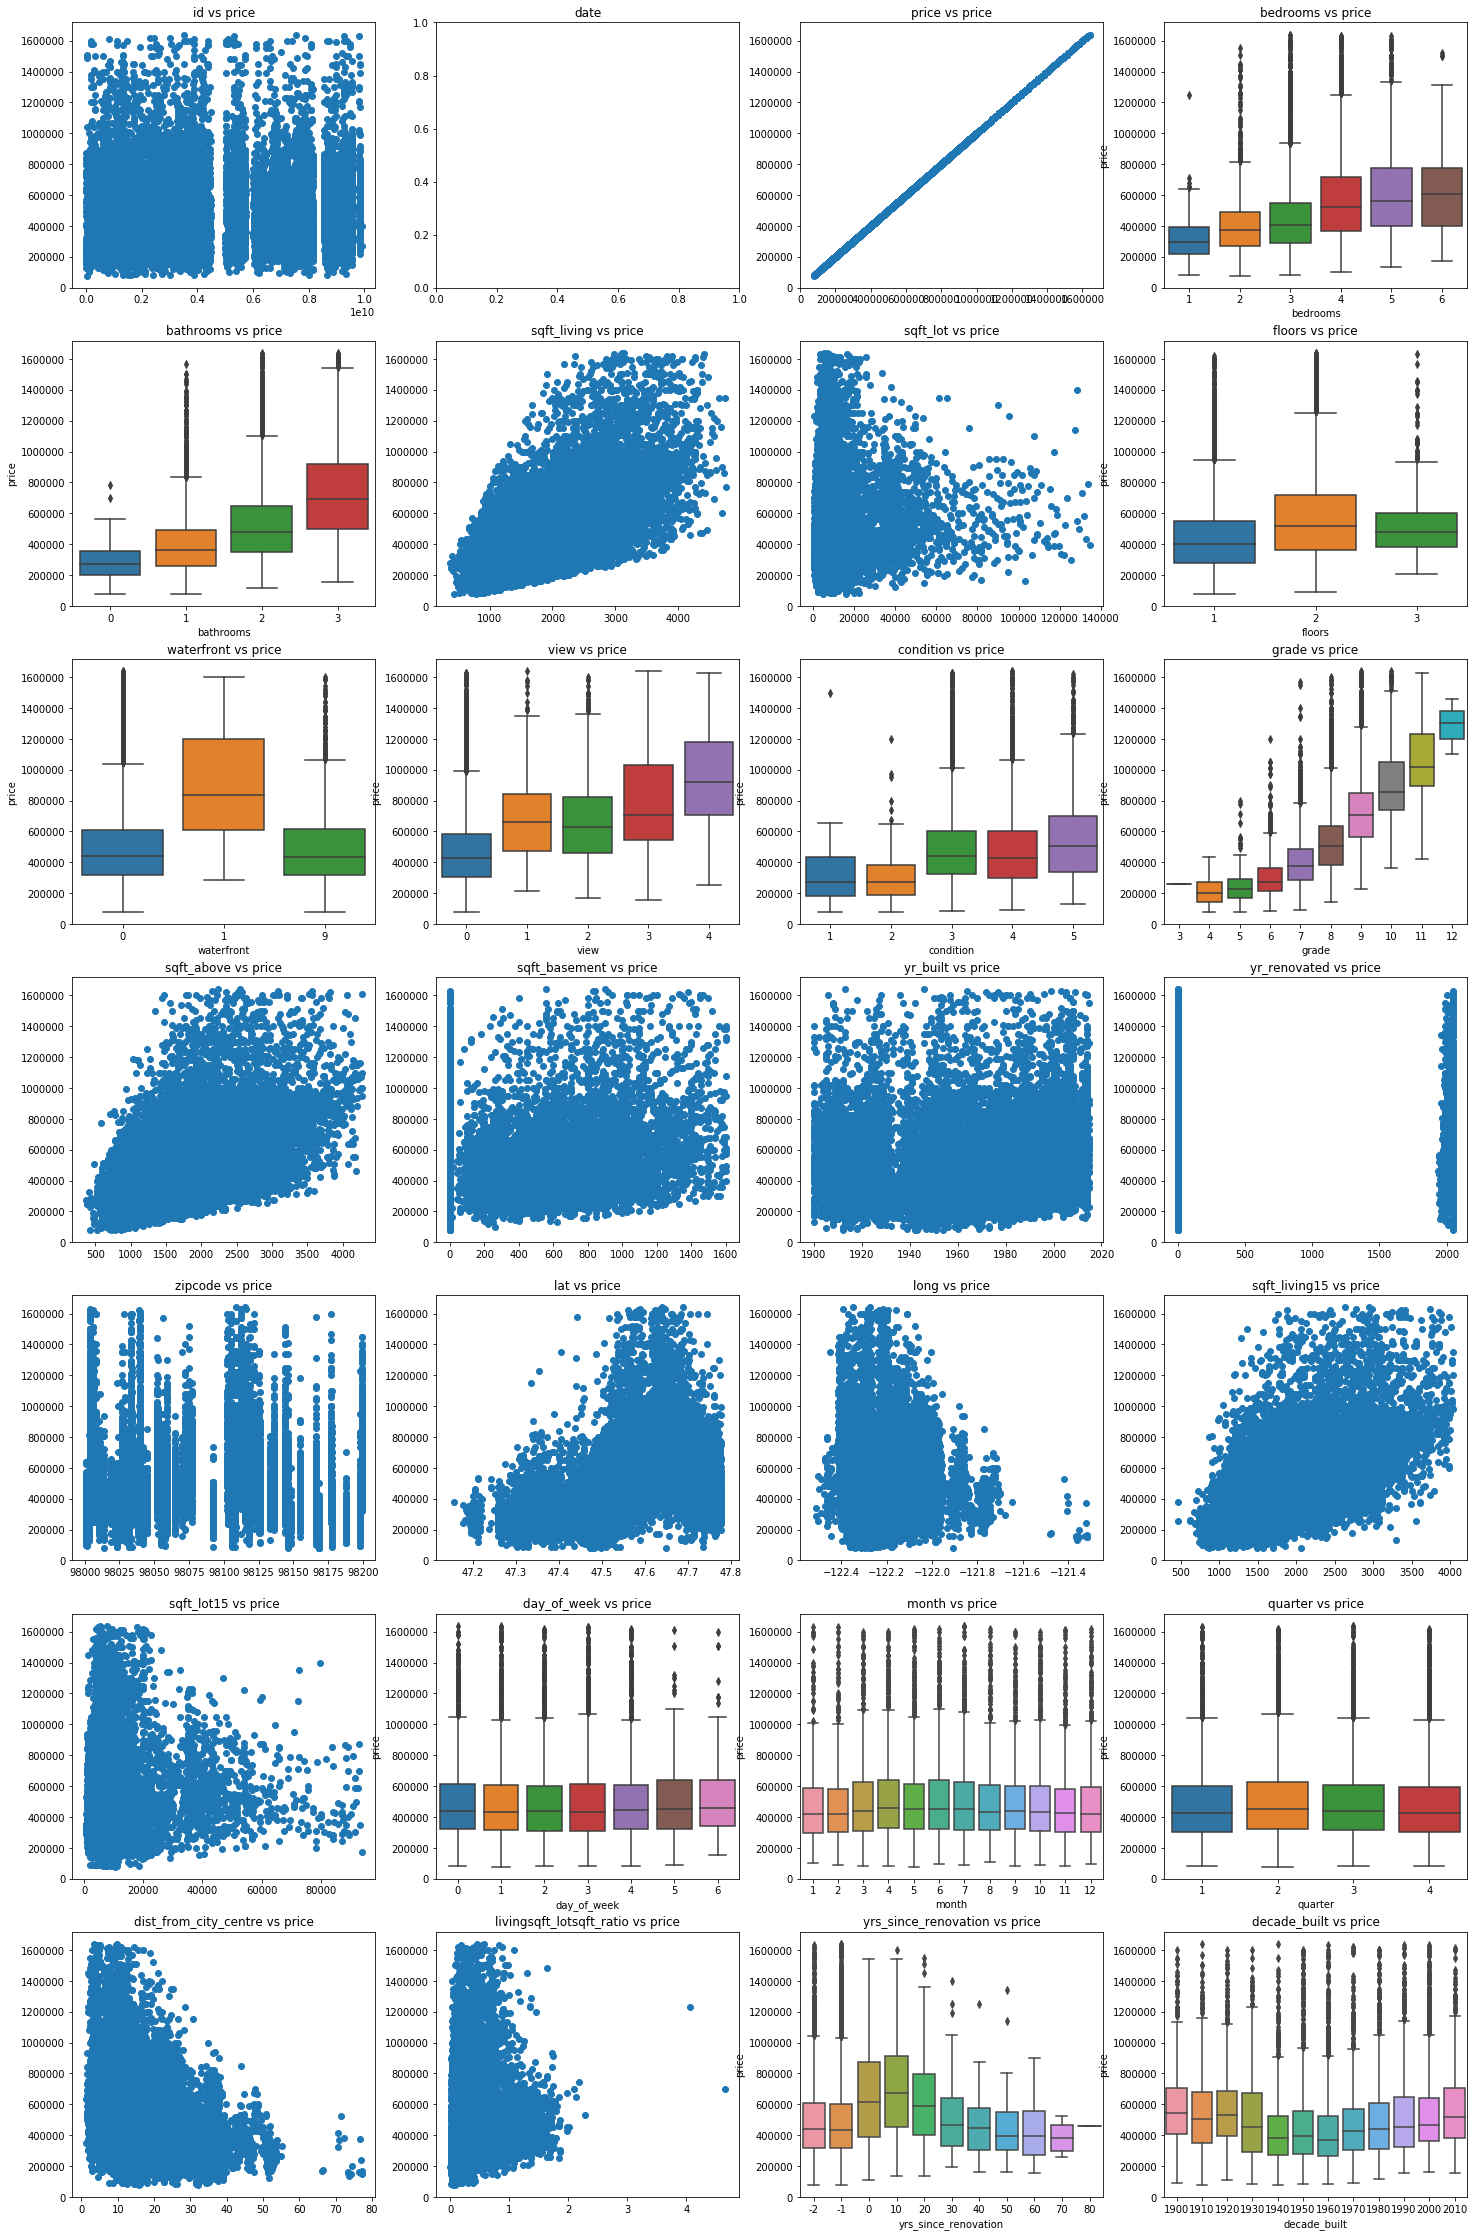

In [115]:
fig3, axes3 = plt.subplots(7, 4, figsize = (25,40))
axes3.shape


for n in range(1,29):
    
    i = df_without_outlier_rows.dtypes.index[n-1]
    
    row = (n-1)//4
    col = (n-1)%4
    
    if str(type(df_without_outlier_rows[str(i)][0])) in ["<class 'numpy.float64'>", "<class 'numpy.int64'>"]:
        
        if (len(df_without_outlier_rows[str(i)].unique()) > 12) and (str(i) not in ['bathrooms']):
        
            ax = axes3[row][col]
            ax.scatter(df_without_outlier_rows[str(i)], df_without_outlier_rows['price'])
            ax.set_title('{}'.format(i) + ' vs price')
            
        
        else:
            ax = axes3[row][col]
            sns.boxplot(str(i), 'price', data=df_without_outlier_rows, ax=ax)
            ax.set_title('{}'.format(i) + ' vs price')
    else:   
        ax = axes3[row][col]
        ax.set_title('{}'.format(i))
        continue

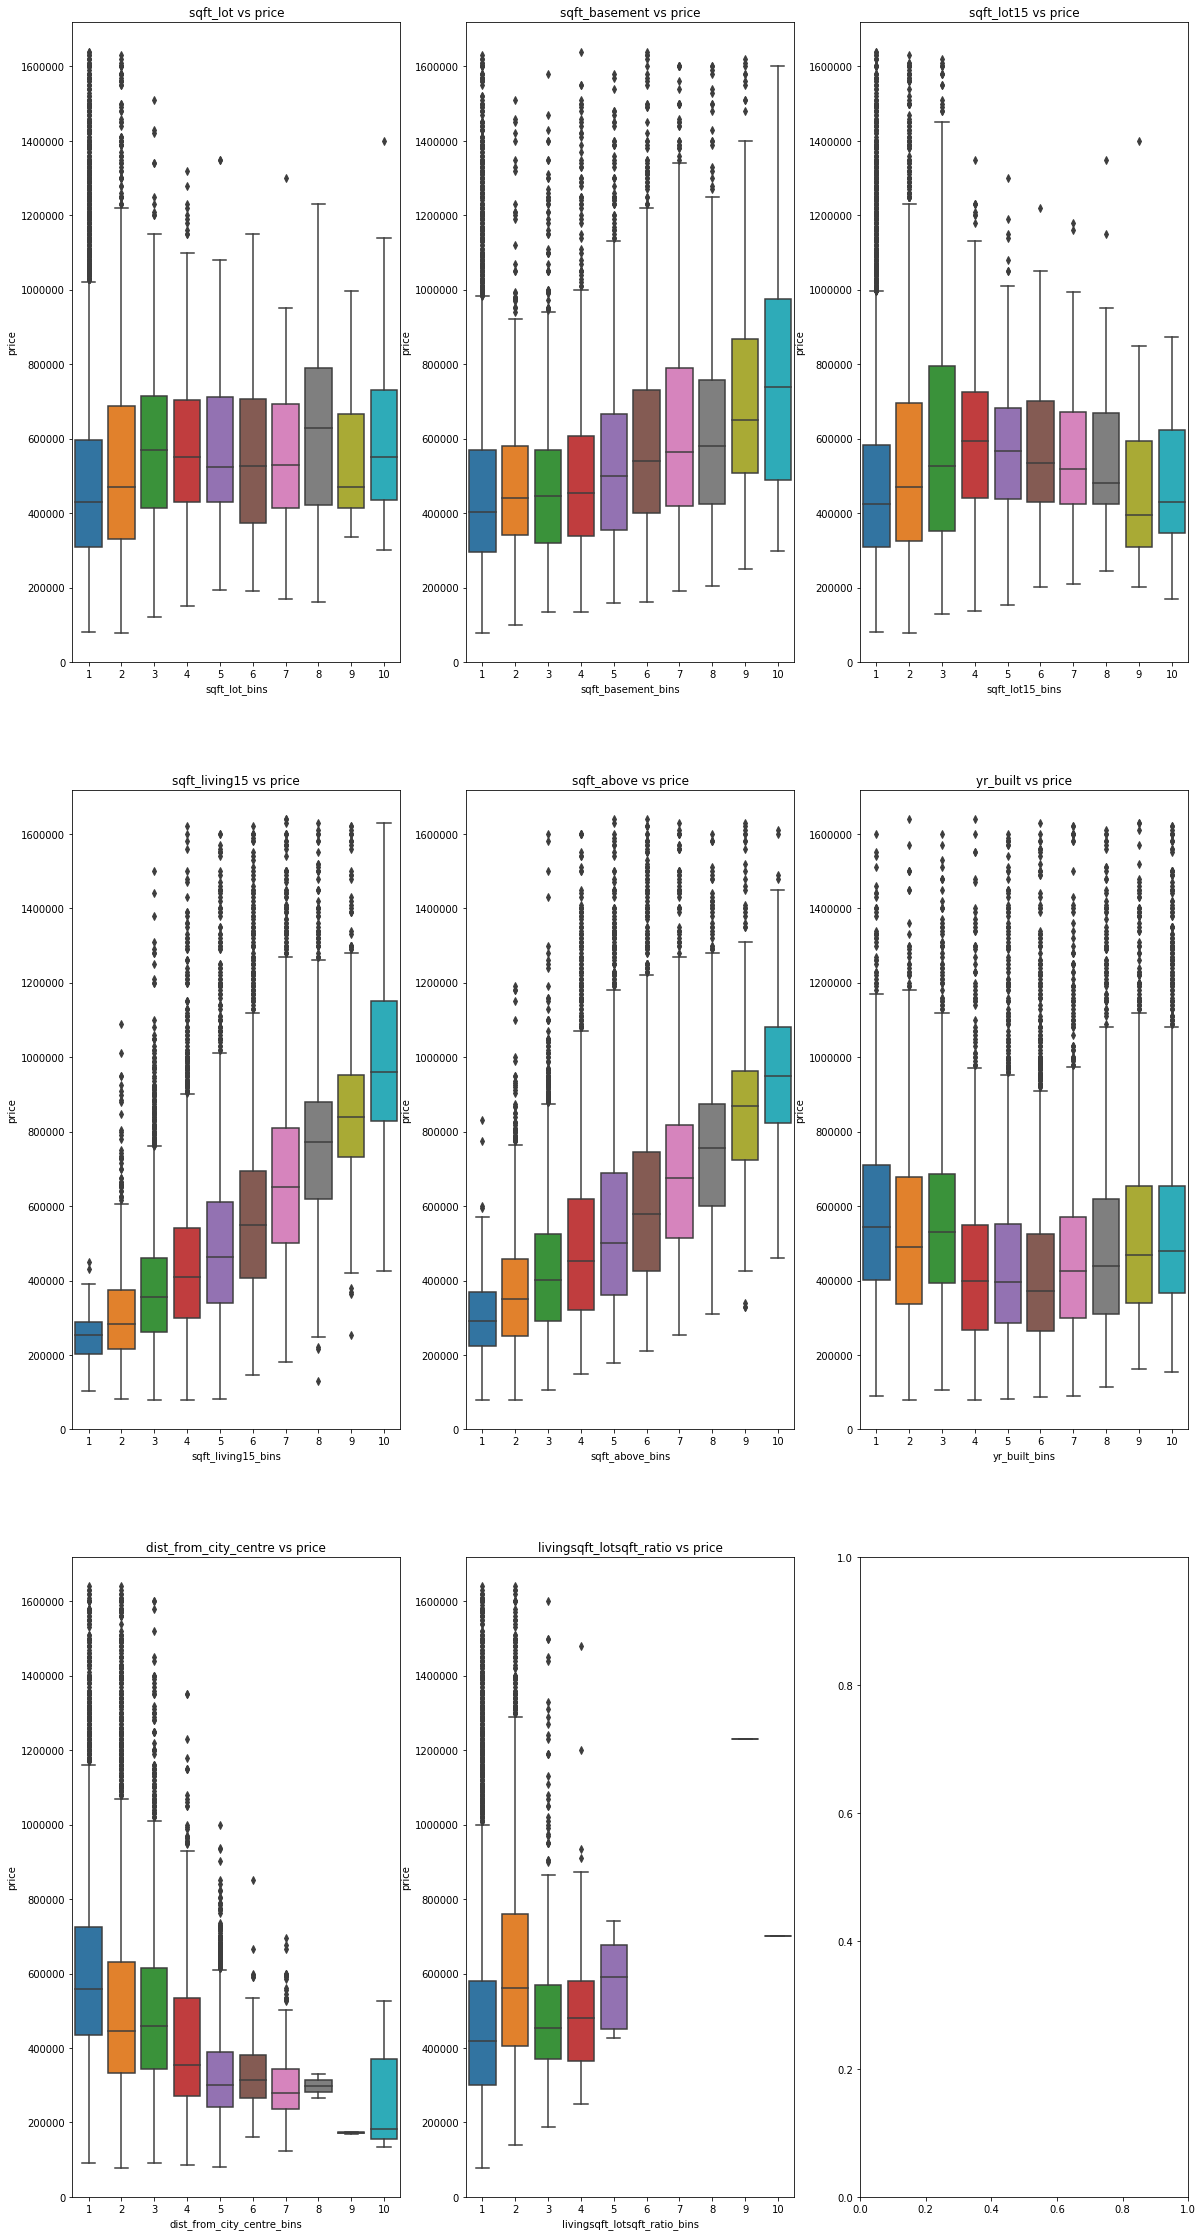

In [116]:
outl_vars = ['sqft_lot', 'sqft_basement', 'sqft_lot15', 'sqft_living15'
             ,'sqft_above', 'yr_built', 'dist_from_city_centre'
             ,'livingsqft_lotsqft_ratio']


for i in outl_vars:
    
    df_without_outlier_rows[(str(i) + '_bins')] = pd.cut(df_without_outlier_rows[str(i)], 10, labels = list(range(1,11)))
    
    


def remove_outliers_and_plot_grouped_boxes(list_of_vars):
    
    fig2, axes2 = plt.subplots(3, 3, figsize = (20,40))

   
    n = (-1)
    for i in list_of_vars:
        
        n += 1
        
        row = (n)//3
        col = (n)%3
        
        ax = axes2[row][col]
        sns.boxplot((str(i) + '_bins'), 'price', data=df_without_outlier_rows, ax=ax)
        ax.set_title('{}'.format(str(i)) + ' vs price')
    

    n = (-1)  
        
remove_outliers_and_plot_grouped_boxes(outl_vars)

Text(0.5, 1.0, 'yr_renovated vs price')

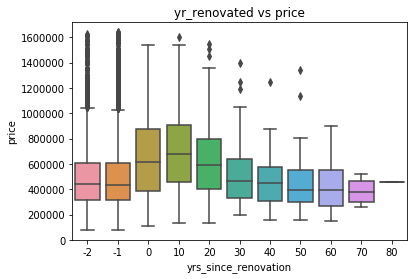

In [117]:
sns.boxplot('yrs_since_renovation', 'price', data=df_without_outlier_rows).set_title('yr_renovated vs price')

In [118]:
for i in ['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'condition', 'sqft_living15', 'grade', 'dist_from_city_centre', 'livingsqft_lotsqft_ratio', 'yrs_since_renovation', 'view']:

    print('{} :'.format(i) + str(round(pearsonr(df_without_outlier_rows[i], df_without_outlier_rows['price'])[0], 2)))

sqft_living :0.62
sqft_lot :0.09
bedrooms :0.29
bathrooms :0.4
floors :0.24
condition :0.05
sqft_living15 :0.55
grade :0.64
dist_from_city_centre :-0.36
livingsqft_lotsqft_ratio :0.19
yrs_since_renovation :0.04
view :0.3


Compare pearson's correlation before outliers removed and after:

* **`sqft_living`**&ensp;&ensp;&emsp;&emsp;&emsp;=> 0.7,&emsp;&emsp;0.62
* **`bathrooms`**&emsp;&emsp;&emsp;&emsp;&emsp;=> 0.51,&emsp;&emsp;0.4
* **`sqft_living15`**&emsp;&emsp;=> 0.59,&emsp;&emsp;0.55
* **`grade`**&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;=> 0.67,&emsp;&emsp;0.64

No real change in correlation scores except with **`sqft_living`** and **`bathrooms`**

In [119]:
df_without_outlier_rows.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,day_of_week,month,quarter,dist_from_city_centre,...,d_decad_1960,d_decad_1970,d_decad_1980,d_decad_1990,d_decad_2000,d_decad_2010,d_yrs_s_-1,d_yrs_s_0,d_yrs_s_10,d_yrs_s_20,d_yrs_s_30,d_yrs_s_40,d_yrs_s_50,d_yrs_s_60,d_yrs_s_70,d_yrs_s_80,sqft_living_bins,sqft_lot_bins,sqft_basement_bins,sqft_lot15_bins,sqft_living15_bins,sqft_above_bins,yr_built_bins,dist_from_city_centre_bins,livingsqft_lotsqft_ratio_bins
0,7129300520,2014-10-13,221900.0,3,1,1180,5650,1,9,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0,10,4,12.479186,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,5,2,1
1,6414100192,2014-12-09,538000.0,3,2,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,1,12,4,12.331758,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1,3,1,4,5,5,2,1
2,5631500400,2015-02-25,180000.0,2,1,770,10000,1,0,0,3,6,770,0,1933,2050,98028,47.7379,-122.233,2720,8062,2,2,1,16.057023,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,7,2,3,2,1
3,2487200875,2014-12-09,604000.0,4,3,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,1,12,4,10.922917,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,1,6,1,3,2,6,2,1
4,1954400510,2015-02-18,510000.0,3,2,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2,2,1,21.688510,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,4,4,8,3,1


## <font color=blue>Regression Model Build<font/>

The aim is to create four regression models from the dataset (with outliers removed):

* 1. One master model that seeks to identify the variables that most impact the price of the property. This model will use the variables highlighted as having the greatest correlation with **`price`** <br><br>
* 2. three sub models that seek to identify the relative impact of specific variables upon **`price`** in order to answer the following questions:<br><br>

    * Which structural features have the largest impact on price?
    * Does the cosmetic condition affect price?
    * Does the size of property and size of land affect price?

create three datasets for each question:<br>
    
    1) Which structural features make the largest impact on price?
    2) Does cosmetic condition affect price?
    3) Does size of property and land affect price?

Will be using the dummy converted variables instead of the original categorical variables for **`bathrooms`**, **`bedrooms`**, **`yrs_since_renovation`**, **`grade`** and **`condition`**

In [120]:
df_without_outlier_rows.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'day_of_week', 'month',
       'quarter', 'dist_from_city_centre', 'livingsqft_lotsqft_ratio',
       'yrs_since_renovation', 'decade_built', 'd_bedro_2', 'd_bedro_3',
       'd_bedro_4', 'd_bedro_5', 'd_bedro_6', 'd_bedro_7', 'd_bedro_8',
       'd_bedro_9', 'd_bedro_10', 'd_bedro_11', 'd_bedro_33', 'd_bathr_1',
       'd_bathr_2', 'd_bathr_3', 'd_bathr_4', 'd_bathr_5', 'd_bathr_6',
       'd_bathr_7', 'd_bathr_8', 'd_floor_2', 'd_floor_3', 'd_water_1',
       'd_water_9', 'd_view_1', 'd_view_2', 'd_view_3', 'd_view_4',
       'd_condi_2', 'd_condi_3', 'd_condi_4', 'd_condi_5', 'd_grade_4',
       'd_grade_5', 'd_grade_6', 'd_grade_7', 'd_grade_8', 'd_grade_9',
       'd_grade_10', 'd_grade_11', 'd_grade_12', 'd_grad

In [121]:
df_without_outlier_rows = df_without_outlier_rows.rename(columns={"d_yrs_s_-1": "d_yrs_s_minus1"}) 
# clean up a naming convention in one specific variable

In [122]:
df_without_outlier_rows.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,day_of_week,month,quarter,dist_from_city_centre,...,d_decad_1960,d_decad_1970,d_decad_1980,d_decad_1990,d_decad_2000,d_decad_2010,d_yrs_s_minus1,d_yrs_s_0,d_yrs_s_10,d_yrs_s_20,d_yrs_s_30,d_yrs_s_40,d_yrs_s_50,d_yrs_s_60,d_yrs_s_70,d_yrs_s_80,sqft_living_bins,sqft_lot_bins,sqft_basement_bins,sqft_lot15_bins,sqft_living15_bins,sqft_above_bins,yr_built_bins,dist_from_city_centre_bins,livingsqft_lotsqft_ratio_bins
0,7129300520,2014-10-13,221900.0,3,1,1180,5650,1,9,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0,10,4,12.479186,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,5,2,1
1,6414100192,2014-12-09,538000.0,3,2,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,1,12,4,12.331758,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1,3,1,4,5,5,2,1
2,5631500400,2015-02-25,180000.0,2,1,770,10000,1,0,0,3,6,770,0,1933,2050,98028,47.7379,-122.233,2720,8062,2,2,1,16.057023,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,7,2,3,2,1
3,2487200875,2014-12-09,604000.0,4,3,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,1,12,4,10.922917,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,1,6,1,3,2,6,2,1
4,1954400510,2015-02-18,510000.0,3,2,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2,2,1,21.688510,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,4,4,8,3,1


Create the 4 datasets to input into our regression model builds:

In [131]:
df_overall = df_without_outlier_rows.loc[:,['price', 'd_bathr_1',
       'd_bathr_2', 'd_bathr_3', 'd_grade_4',
       'd_grade_5', 'd_grade_6', 'd_grade_7', 'd_grade_8', 'd_grade_9',
       'd_grade_10', 'd_grade_11', 'd_grade_12', 'sqft_living', 'sqft_living15']]


df_structural = df_without_outlier_rows.loc[:,['price', 'd_bedro_2', 'd_bedro_3',
       'd_bedro_4', 'd_bedro_5', 'd_bedro_6', 'd_bathr_1',
       'd_bathr_2', 'd_bathr_3', 'd_yrs_s_minus1', 'd_yrs_s_0', 'd_yrs_s_10',
       'd_yrs_s_20', 'd_yrs_s_30', 'd_yrs_s_40', 'd_yrs_s_50', 'd_yrs_s_60',
       'd_yrs_s_70', 'd_yrs_s_80']]

df_cosmetic = df_without_outlier_rows.loc[:,['price', 'd_condi_2', 'd_condi_3', 'd_condi_4', 'd_condi_5', 'd_yrs_s_minus1', 'd_yrs_s_0', 'd_yrs_s_10',
       'd_yrs_s_20', 'd_yrs_s_30', 'd_yrs_s_40', 'd_yrs_s_50', 'd_yrs_s_60',
       'd_yrs_s_70', 'd_yrs_s_80']]

df_size = df_without_outlier_rows.loc[:,['price', 'sqft_living', 'sqft_lot', 'livingsqft_lotsqft_ratio']]


In [132]:
df_overall.head()

,price,d_bathr_1,d_bathr_2,d_bathr_3,d_grade_4,d_grade_5,d_grade_6,d_grade_7,d_grade_8,d_grade_9,d_grade_10,d_grade_11,d_grade_12,sqft_living,sqft_living15
0,221900.0,1,0,0,0,0,0,1,0,0,0,0,0,1180,1340
1,538000.0,0,1,0,0,0,0,1,0,0,0,0,0,2570,1690
2,180000.0,1,0,0,0,0,1,0,0,0,0,0,0,770,2720
3,604000.0,0,0,1,0,0,0,1,0,0,0,0,0,1960,1360
4,510000.0,0,1,0,0,0,0,0,1,0,0,0,0,1680,1800


check for multicollinearity between predictor variables:

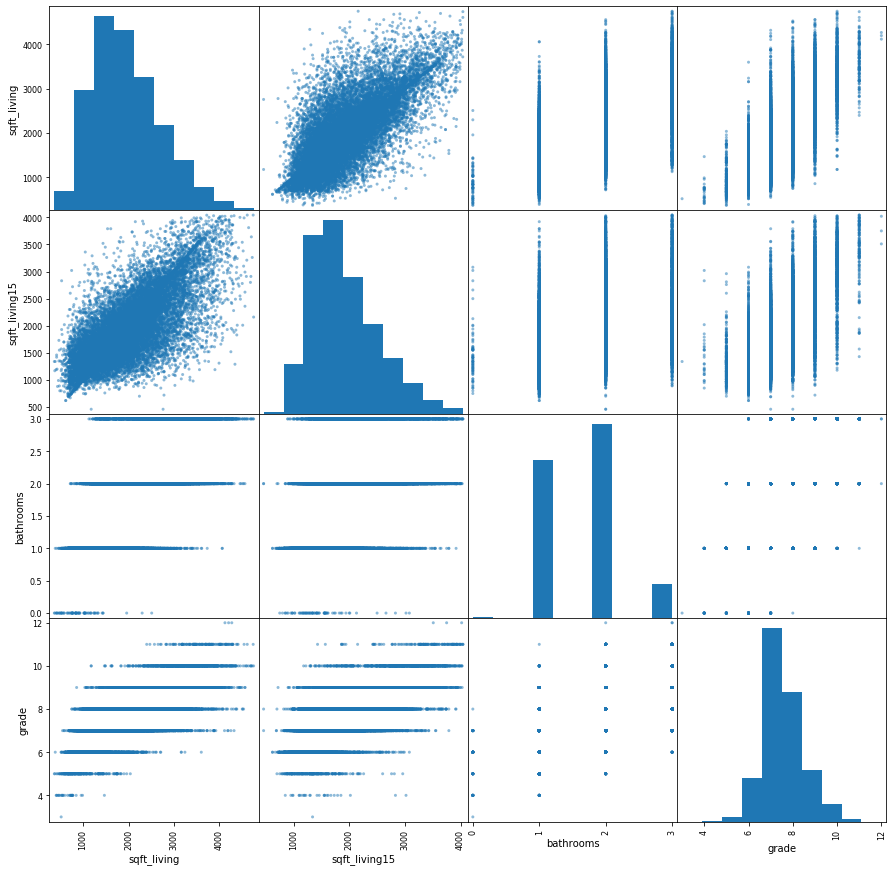

,sqft_living,sqft_living15,bathrooms,grade
sqft_living,1.000000,0.740486,0.624090,0.711488
sqft_living15,0.740486,1.000000,0.448425,0.669972
bathrooms,0.624090,0.448425,1.000000,0.541938
grade,0.711488,0.669972,0.541938,1.000000


In [133]:
a = df_without_outlier_rows.loc[:,['sqft_living', 'sqft_living15', 'bathrooms', 'grade']]

pd.plotting.scatter_matrix(a,figsize  = [15, 15]);
plt.show()

a.corr()

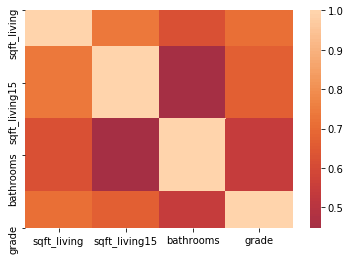

In [134]:
sns.heatmap(a.corr(), center=0);

Need to exclude **`sqft_living`** from the regrrssionmodel build as it is highly correlated with the **`sqft_living15`**, **`bathrooms`**, **`grade`**

In [136]:
outcome = 'price'
predictors = df_overall.drop(['price', 'sqft_living', 'd_grade_4',        # build model on just 'number of bathrooms'
       'd_grade_5', 'd_grade_6', 'd_grade_7', 'd_grade_8', 'd_grade_9',
       'd_grade_10', 'd_grade_11', 'd_grade_12', 'sqft_living15'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=df_overall).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     1372.
Date:                Wed, 22 Jan 2020   Prob (F-statistic):               0.00
Time:                        08:16:41   Log-Likelihood:            -2.7674e+05
No. Observations:               20156   AIC:                         5.535e+05
Df Residuals:                   20152   BIC:                         5.535e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.916e+05    2.6e+04     11.218      0.000    2.41e+05    3.43e+05
d_bathr_1   1.042e+05   2.61e+04      3.988      0.000     5.3e+04    1.55e+05
d_bathr_2   2.351e+05   2.61e+04      9.012      0.000    1.84e+05    2.86e+05
d_bathr_3    4.51e+05   2.65e+04     17.002      0.000    3.99e+05    5.03e+05
==============================================================================
Omnibus:                     4276.869   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9545.836
Skew:                           1.217   Prob(JB):                         0.00
Kurtosis:                       5.333   Cond. No.                         39.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [138]:
outcome = 'price'
predictors = df_overall.drop(['price', 'sqft_living', 'd_grade_4',        # build model on 'number of bathrooms'
       'd_grade_5', 'd_grade_6', 'd_grade_7', 'd_grade_8', 'd_grade_9',   # and 'sqft_living15'
       'd_grade_10', 'd_grade_11', 'd_grade_12'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=df_overall).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     2738.
Date:                Wed, 22 Jan 2020   Prob (F-statistic):               0.00
Time:                        08:16:59   Log-Likelihood:            -2.7424e+05
No. Observations:               20156   AIC:                         5.485e+05
Df Residuals:                   20151   BIC:                         5.485e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      8045.7609   2.33e+04      0.346      0.730   -3.76e+04    5.37e+04
d_bathr_1      7.741e+04   2.31e+04      3.356      0.001    3.22e+04    1.23e+05
d_bathr_2      1.103e+05   2.31e+04      4.774      0.000     6.5e+04    1.56e+05
d_bathr_3      2.774e+05   2.35e+04     11.783      0.000    2.31e+05    3.24e+05
sqft_living15   194.2781      2.578     75.354      0.000     189.225     199.332
==============================================================================
Omnibus:                     4085.514   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9625.158
Skew:                           1.142   Prob(JB):                         0.00
Kurtosis:                       5.499   Cond. No.                     6.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [139]:
outcome = 'price'
predictors = df_overall.drop(['price', 'sqft_living'],                   # build model on number of bathrooms,
             axis=1)                                                     # sqft_living15 and grade
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=df_overall).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     1310.
Date:                Wed, 22 Jan 2020   Prob (F-statistic):               0.00
Time:                        08:17:13   Log-Likelihood:            -2.7244e+05
No. Observations:               20156   AIC:                         5.449e+05
Df Residuals:                   20142   BIC:                         5.450e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.443e+05    1.8e+05      0.804      0.422   -2.08e+05    4.96e+05
d_bathr_1      8218.7491   2.24e+04      0.367      0.713   -3.56e+04    5.21e+04
d_bathr_2     -5344.5356   2.25e+04     -0.237      0.812   -4.95e+04    3.88e+04
d_bathr_3      1.045e+05   2.29e+04      4.560      0.000    5.96e+04    1.49e+05
d_grade_4     -6.715e+04   1.83e+05     -0.367      0.714   -4.26e+05    2.92e+05
d_grade_5     -2.414e+04   1.81e+05     -0.133      0.894   -3.79e+05    3.31e+05
d_grade_6      2.852e+04   1.81e+05      0.158      0.875   -3.26e+05    3.83e+05
d_grade_7      1.037e+05   1.81e+05      0.573      0.566   -2.51e+05    4.58e+05
d_grade_8      2.015e+05   1.81e+05      1.114      0.265   -1.53e+05    5.56e+05
d_grade_9      3.475e+05   1.81e+05      1.920      0.055   -7182.390    7.02e+05
d_grade_10     4.755e+05   1.81e+05      2.626      0.009    1.21e+05     8.3e+05
d_grade_11     5.809e+05   1.82e+05      3.198      0.001    2.25e+05    9.37e+05
d_grade_12     7.441e+05   2.09e+05      3.567      0.000    3.35e+05    1.15e+06
sqft_living15    87.8694      2.909     30.202      0.000      82.167      93.572
==============================================================================
Omnibus:                     3900.550   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9286.566
Skew:                           1.089   Prob(JB):                         0.00
Kurtosis:                       5.513   Cond. No.                     9.09e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared = **0.46**

#### Question 1 - Which structural features make the largest impact on price?

In [140]:
df_structural.columns

Index(['price', 'd_bedro_2', 'd_bedro_3', 'd_bedro_4', 'd_bedro_5',
       'd_bedro_6', 'd_bathr_1', 'd_bathr_2', 'd_bathr_3', 'd_yrs_s_minus1',
       'd_yrs_s_0', 'd_yrs_s_10', 'd_yrs_s_20', 'd_yrs_s_30', 'd_yrs_s_40',
       'd_yrs_s_50', 'd_yrs_s_60', 'd_yrs_s_70', 'd_yrs_s_80'],
      dtype='object')

In [142]:
# build model on 'number of bedrooms' only

outcome = 'price'
predictors = df_structural.drop(['price', 'd_bathr_1', 'd_bathr_2', 'd_bathr_3', 'd_yrs_s_minus1',
       'd_yrs_s_0', 'd_yrs_s_10', 'd_yrs_s_20', 'd_yrs_s_30', 'd_yrs_s_40',
       'd_yrs_s_50', 'd_yrs_s_60', 'd_yrs_s_70', 'd_yrs_s_80'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=df_structural).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     406.8
Date:                Wed, 22 Jan 2020   Prob (F-statistic):               0.00
Time:                        08:19:17   Log-Likelihood:            -2.7764e+05
No. Observations:               20156   AIC:                         5.553e+05
Df Residuals:                   20150   BIC:                         5.553e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.179e+05   1.69e+04     18.863      0.000    2.85e+05    3.51e+05
d_bedro_2   7.942e+04   1.74e+04      4.554      0.000    4.52e+04    1.14e+05
d_bedro_3   1.318e+05    1.7e+04      7.744      0.000    9.85e+04    1.65e+05
d_bedro_4   2.522e+05   1.71e+04     14.743      0.000    2.19e+05    2.86e+05
d_bedro_5   3.019e+05    1.8e+04     16.731      0.000    2.66e+05    3.37e+05
d_bedro_6   3.039e+05   2.38e+04     12.748      0.000    2.57e+05    3.51e+05
==============================================================================
Omnibus:                     4794.229   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11658.043
Skew:                           1.319   Prob(JB):                         0.00
Kurtosis:                       5.631   Cond. No.                         30.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [143]:
# build model on 'number of bedrroms' and 'number of bathrooms'

outcome = 'price'
predictors = df_structural.drop(['price', 'd_yrs_s_minus1',
       'd_yrs_s_0', 'd_yrs_s_10', 'd_yrs_s_20', 'd_yrs_s_30', 'd_yrs_s_40',
       'd_yrs_s_50', 'd_yrs_s_60', 'd_yrs_s_70', 'd_yrs_s_80'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=df_structural).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     603.6
Date:                Wed, 22 Jan 2020   Prob (F-statistic):               0.00
Time:                        08:19:53   Log-Likelihood:            -2.7645e+05
No. Observations:               20156   AIC:                         5.529e+05
Df Residuals:                   20147   BIC:                         5.530e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.527e+05   2.77e+04      9.134      0.000    1.98e+05    3.07e+05
d_bedro_2   5.303e+04   1.68e+04      3.156      0.002    2.01e+04     8.6e+04
d_bedro_3   6.208e+04   1.65e+04      3.754      0.000    2.97e+04    9.45e+04
d_bedro_4   1.402e+05   1.67e+04      8.383      0.000    1.07e+05    1.73e+05
d_bedro_5   1.506e+05   1.76e+04      8.534      0.000    1.16e+05    1.85e+05
d_bedro_6   1.345e+05    2.3e+04      5.851      0.000    8.95e+04     1.8e+05
d_bathr_1   6.973e+04   2.64e+04      2.641      0.008     1.8e+04    1.21e+05
d_bathr_2   1.734e+05   2.65e+04      6.537      0.000    1.21e+05    2.25e+05
d_bathr_3   3.699e+05    2.7e+04     13.698      0.000    3.17e+05    4.23e+05
==============================================================================
Omnibus:                     4298.737   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9904.637
Skew:                           1.208   Prob(JB):                         0.00
Kurtosis:                       5.440   Cond. No.                         45.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [144]:
# build model on 'number of bedrooms', 'number of bathrooms' and 'yrs since renovated'

outcome = 'price'
predictors = df_structural.drop(['price'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=df_structural).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     282.5
Date:                Wed, 22 Jan 2020   Prob (F-statistic):               0.00
Time:                        08:20:55   Log-Likelihood:            -2.7634e+05
No. Observations:               20156   AIC:                         5.527e+05
Df Residuals:                   20137   BIC:                         5.529e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.517e+05   2.77e+04      9.082      0.000    1.97e+05    3.06e+05
d_bedro_2       5.553e+04   1.67e+04      3.316      0.001    2.27e+04    8.84e+04
d_bedro_3       6.526e+04   1.65e+04      3.959      0.000    3.29e+04    9.76e+04
d_bedro_4       1.439e+05   1.67e+04      8.631      0.000    1.11e+05    1.77e+05
d_bedro_5       1.551e+05   1.76e+04      8.823      0.000    1.21e+05     1.9e+05
d_bedro_6       1.362e+05   2.29e+04      5.948      0.000    9.13e+04    1.81e+05
d_bathr_1       7.045e+04   2.63e+04      2.681      0.007    1.89e+04    1.22e+05
d_bathr_2        1.73e+05   2.64e+04      6.554      0.000    1.21e+05    2.25e+05
d_bathr_3       3.656e+05   2.69e+04     13.601      0.000    3.13e+05    4.18e+05
d_yrs_s_minus1 -6746.4042   4018.450     -1.679      0.093   -1.46e+04    1130.087
d_yrs_s_0        1.33e+05   1.79e+04      7.410      0.000    9.78e+04    1.68e+05
d_yrs_s_10      1.706e+05   1.84e+04      9.296      0.000    1.35e+05    2.07e+05
d_yrs_s_20      1.245e+05   1.92e+04      6.487      0.000    8.69e+04    1.62e+05
d_yrs_s_30      5.461e+04   2.75e+04      1.987      0.047     734.241    1.08e+05
d_yrs_s_40     -6681.3736   3.65e+04     -0.183      0.855   -7.82e+04    6.49e+04
d_yrs_s_50      8265.8965   4.37e+04      0.189      0.850   -7.75e+04     9.4e+04
d_yrs_s_60       3.46e+04   7.72e+04      0.448      0.654   -1.17e+05    1.86e+05
d_yrs_s_70     -2.231e+04   1.09e+05     -0.205      0.838   -2.36e+05    1.91e+05
d_yrs_s_80      7.252e+04   2.18e+05      0.333      0.739   -3.55e+05       5e+05
==============================================================================
Omnibus:                     4245.473   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9762.193
Skew:                           1.195   Prob(JB):                         0.00
Kurtosis:                       5.432   Cond. No.                         223.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared = **0.2**

making structural changes to a property such as adding a bathroom(s), bedroom(s) or simplty renovating only accounts for 20% in the change in price of a property

#### Question 2 - How much impact does cosmetic condition have on price?

In [145]:
df_cosmetic.columns

Index(['price', 'd_condi_2', 'd_condi_3', 'd_condi_4', 'd_condi_5',
       'd_yrs_s_minus1', 'd_yrs_s_0', 'd_yrs_s_10', 'd_yrs_s_20', 'd_yrs_s_30',
       'd_yrs_s_40', 'd_yrs_s_50', 'd_yrs_s_60', 'd_yrs_s_70', 'd_yrs_s_80'],
      dtype='object')

In [146]:
# build model on 'condition' only

outcome = 'price'
predictors = df_cosmetic.drop(['price',
       'd_yrs_s_minus1', 'd_yrs_s_0', 'd_yrs_s_10', 'd_yrs_s_20', 'd_yrs_s_30',
       'd_yrs_s_40', 'd_yrs_s_50', 'd_yrs_s_60', 'd_yrs_s_70', 'd_yrs_s_80'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=df_cosmetic).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     50.18
Date:                Wed, 22 Jan 2020   Prob (F-statistic):           4.25e-42
Time:                        08:23:11   Log-Likelihood:            -2.7851e+05
No. Observations:               20156   AIC:                         5.570e+05
Df Residuals:                   20151   BIC:                         5.571e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.436e+05   4.58e+04      7.496      0.000    2.54e+05    4.33e+05
d_condi_2  -3.302e+04   4.98e+04     -0.663      0.507   -1.31e+05    6.46e+04
d_condi_3   1.476e+05   4.59e+04      3.217      0.001    5.77e+04    2.38e+05
d_condi_4   1.381e+05    4.6e+04      3.005      0.003     4.8e+04    2.28e+05
d_condi_5   2.073e+05   4.62e+04      4.483      0.000    1.17e+05    2.98e+05
==============================================================================
Omnibus:                     4955.365   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11805.871
Skew:                           1.374   Prob(JB):                         0.00
Kurtosis:                       5.551   Cond. No.                         74.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [147]:
# build model on 'condition' and 'yrs since renovation'

outcome = 'price'
predictors = df_cosmetic.drop(['price'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=df_cosmetic).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     32.50
Date:                Wed, 22 Jan 2020   Prob (F-statistic):           3.45e-87
Time:                        08:26:22   Log-Likelihood:            -2.7839e+05
No. Observations:               20156   AIC:                         5.568e+05
Df Residuals:                   20141   BIC:                         5.569e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        3.42e+05   4.57e+04      7.483      0.000    2.52e+05    4.32e+05
d_condi_2      -2.893e+04   4.95e+04     -0.584      0.559   -1.26e+05    6.81e+04
d_condi_3       1.475e+05   4.56e+04      3.233      0.001    5.81e+04    2.37e+05
d_condi_4       1.417e+05   4.57e+04      3.102      0.002    5.22e+04    2.31e+05
d_condi_5       2.116e+05    4.6e+04      4.602      0.000    1.21e+05    3.02e+05
d_yrs_s_minus1 -4404.8358   4446.303     -0.991      0.322   -1.31e+04    4310.281
d_yrs_s_0       1.766e+05   1.99e+04      8.885      0.000    1.38e+05    2.16e+05
d_yrs_s_10      2.167e+05   2.03e+04     10.671      0.000    1.77e+05    2.56e+05
d_yrs_s_20       1.37e+05   2.12e+04      6.455      0.000    9.54e+04    1.79e+05
d_yrs_s_30      3.382e+04   3.04e+04      1.112      0.266   -2.58e+04    9.34e+04
d_yrs_s_40     -1.613e+04   4.04e+04     -0.399      0.690   -9.53e+04     6.3e+04
d_yrs_s_50     -3.152e+04   4.84e+04     -0.651      0.515   -1.26e+05    6.33e+04
d_yrs_s_60     -6.224e+04   8.53e+04     -0.729      0.466    -2.3e+05    1.05e+05
d_yrs_s_70     -1.032e+05   1.21e+05     -0.855      0.392    -3.4e+05    1.33e+05
d_yrs_s_80     -9.365e+04   2.41e+05     -0.388      0.698   -5.66e+05    3.79e+05
==============================================================================
Omnibus:                     4861.748   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11515.061
Skew:                           1.351   Prob(JB):                         0.00
Kurtosis:                       5.533   Cond. No.                         211.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared = **0.02**

making cosmetic improvements to a property such as improving condition or simply renovating only accounts for 2% in the change in price of a property. Minimal impact.

#### Question 3 - Are higher prices associated with larger properties, larger land or both?

In [148]:
df_size.columns

Index(['price', 'sqft_living', 'sqft_lot', 'livingsqft_lotsqft_ratio'], dtype='object')

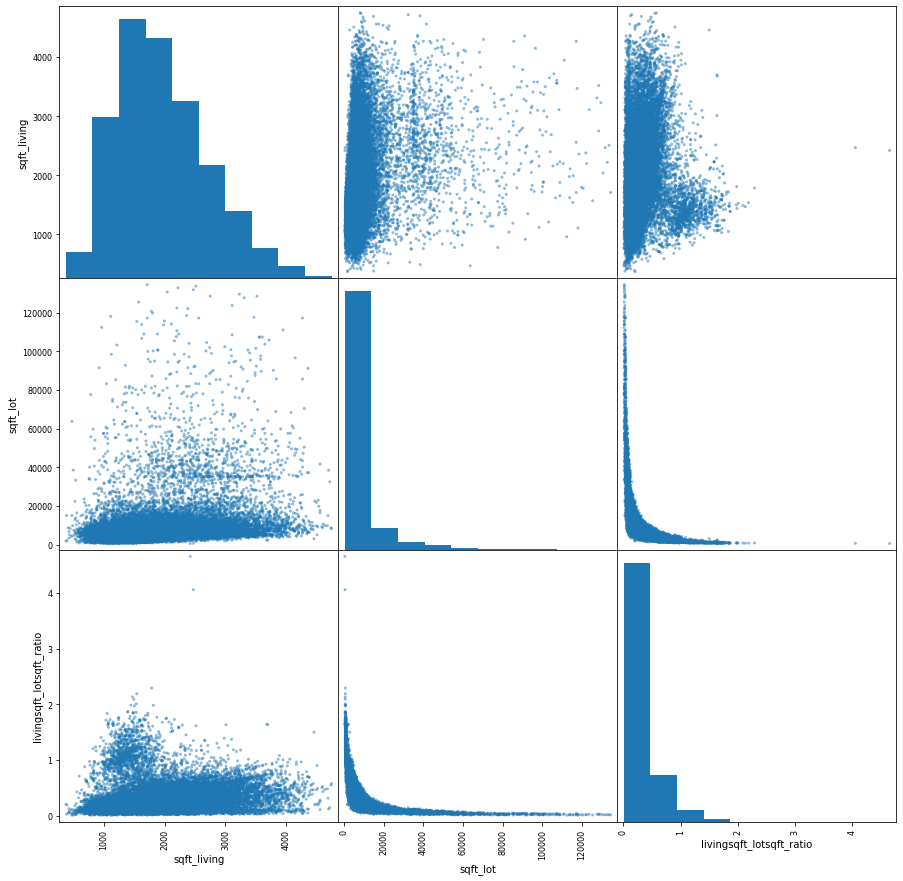

,sqft_living,sqft_lot,livingsqft_lotsqft_ratio
sqft_living,1.000000,0.219854,0.113684
sqft_lot,0.219854,1.000000,-0.428193
livingsqft_lotsqft_ratio,0.113684,-0.428193,1.000000


In [149]:
a = df_without_outlier_rows.loc[:,['sqft_living', 'sqft_lot', 'livingsqft_lotsqft_ratio']]

pd.plotting.scatter_matrix(a,figsize  = [15, 15]);
plt.show()

a.corr()

In [150]:
# build model on 'living sqft' and 'lot sqft'

outcome = 'price'
predictors = df_size.drop(['price', 'livingsqft_lotsqft_ratio'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=df_size).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     6459.
Date:                Wed, 22 Jan 2020   Prob (F-statistic):               0.00
Time:                        08:29:46   Log-Likelihood:            -2.7362e+05
No. Observations:               20156   AIC:                         5.472e+05
Df Residuals:                   20153   BIC:                         5.473e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    9.395e+04   3803.401     24.700      0.000    8.65e+04    1.01e+05
sqft_living   208.0297      1.850    112.430      0.000     204.403     211.656
sqft_lot       -0.9958      0.118     -8.467      0.000      -1.226      -0.765
==============================================================================
Omnibus:                     3710.031   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8509.334
Skew:                           1.053   Prob(JB):                         0.00
Kurtosis:                       5.386   Cond. No.                     4.39e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [151]:
# build model on 'living sqft - lot sqft ratio' only

outcome = 'price'
predictors = df_size.drop(['price', 'sqft_living', 'sqft_lot'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=df_size).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     749.6
Date:                Wed, 22 Jan 2020   Prob (F-statistic):          4.49e-162
Time:                        08:30:42   Log-Likelihood:            -2.7824e+05
No. Observations:               20156   AIC:                         5.565e+05
Df Residuals:                   20154   BIC:                         5.565e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 4.354e+05   2661.471    163.587      0.000     4.3e+05    4.41e+05
livingsqft_lotsqft_ratio  1.712e+05   6253.528     27.379      0.000    1.59e+05    1.83e+05
==============================================================================
Omnibus:                     5088.178   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12378.068
Skew:                           1.401   Prob(JB):                         0.00
Kurtosis:                       5.625   Cond. No.                         4.14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared (**`sqft_living`**, **`sqft_lot`**) = **0.39** <br>
R-squared (**`livingsqft_lotsqft_ratio`**) = **0.04**

size of living space have a much greater association with price than the actual size of land

### BONUS REGRESSION

For the purpose of obtaining the highest R-squared possible

In [153]:
# Only considering variables that exhibited some level of correlation with price

df_for_pairwise = df_without_outlier_rows.loc[:,['price', 'sqft_living',
       'sqft_lot',
       'sqft_above', 'sqft_basement',
       'sqft_living15', 'sqft_lot15', 'month',
       'dist_from_city_centre', 'livingsqft_lotsqft_ratio']]

In [154]:
df_for_pairwise.corr()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,month,dist_from_city_centre,livingsqft_lotsqft_ratio
price,1.000000,0.623256,0.091607,0.517266,0.247272,0.554908,0.083862,-0.013106,-0.362425,0.189367
sqft_living,0.623256,1.000000,0.219854,0.851475,0.357996,0.740486,0.218183,0.015473,0.112697,0.113684
sqft_lot,0.091607,0.219854,1.000000,0.210172,0.039712,0.262054,0.820933,0.005172,0.279292,-0.428193
sqft_above,0.517266,0.851475,0.210172,1.000000,-0.175539,0.714425,0.213741,0.013462,0.235714,0.088123
sqft_basement,0.247272,0.357996,0.039712,-0.175539,1.000000,0.119949,0.029899,0.007376,-0.204210,0.055131
sqft_living15,0.554908,0.740486,0.262054,0.714425,0.119949,1.000000,0.283777,0.003455,0.164263,-0.030074
sqft_lot15,0.083862,0.218183,0.820933,0.213741,0.029899,0.283777,1.000000,-0.000777,0.304933,-0.426528
month,-0.013106,0.015473,0.005172,0.013462,0.007376,0.003455,-0.000777,1.000000,-0.012548,0.010190
dist_from_city_centre,-0.362425,0.112697,0.279292,0.235714,-0.204210,0.164263,0.304933,-0.012548,1.000000,-0.312717
livingsqft_lotsqft_ratio,0.189367,0.113684,-0.428193,0.088123,0.055131,-0.030074,-0.426528,0.010190,-0.312717,1.000000


In [155]:
abs(df_for_pairwise.corr()) > 0.6

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,month,dist_from_city_centre,livingsqft_lotsqft_ratio
price,True,True,False,False,False,False,False,False,False,False
sqft_living,True,True,False,True,False,True,False,False,False,False
sqft_lot,False,False,True,False,False,False,True,False,False,False
sqft_above,False,True,False,True,False,True,False,False,False,False
sqft_basement,False,False,False,False,True,False,False,False,False,False
sqft_living15,False,True,False,True,False,True,False,False,False,False
sqft_lot15,False,False,True,False,False,False,True,False,False,False
month,False,False,False,False,False,False,False,True,False,False
dist_from_city_centre,False,False,False,False,False,False,False,False,True,False
livingsqft_lotsqft_ratio,False,False,False,False,False,False,False,False,False,True


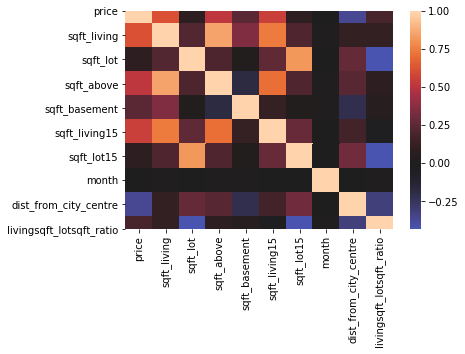

In [156]:

sns.heatmap(df_for_pairwise.corr(), center=0);

In [157]:
# excluding variables that showed high multicollinearity

df_final = df_without_outlier_rows.loc[:,['price', 'sqft_living',
       'sqft_lot',
       'month',
       'dist_from_city_centre',
        'd_bedro_2', 'd_bedro_3',
       'd_bedro_4', 'd_bedro_5', 'd_bedro_6', 'd_bathr_1',
       'd_bathr_2', 'd_bathr_3', 'd_bathr_4', 'd_bathr_5', 'd_floor_2', 'd_floor_3', 'd_water_1',
       'd_water_9', 'd_view_1', 'd_view_2', 'd_view_3', 'd_view_4',
       'd_condi_2', 'd_condi_3', 'd_condi_4', 'd_condi_5', 'd_decad_1910',
       'd_decad_1920', 'd_decad_1930', 'd_decad_1940', 'd_decad_1950',
       'd_decad_1960', 'd_decad_1970', 'd_decad_1980', 'd_decad_1990',
       'd_decad_2000', 'd_decad_2010', 'd_yrs_s_minus1', 'd_yrs_s_0',
       'd_yrs_s_10', 'd_yrs_s_20', 'd_yrs_s_30', 'd_yrs_s_40', 'd_yrs_s_50',
       'd_yrs_s_60', 'd_yrs_s_70', 'd_yrs_s_80']]



In [158]:
outcome = 'price'
predictors = df_final.drop(['price'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=df_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     764.0
Date:                Wed, 22 Jan 2020   Prob (F-statistic):               0.00
Time:                        08:36:14   Log-Likelihood:            -2.6857e+05
No. Observations:               20156   AIC:                         5.372e+05
Df Residuals:                   20110   BIC:                         5.376e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               2.19e+05    3.4e+04      6.449      0.000    1.52e+05    2.86e+05
sqft_living             207.4421      2.262     91.712      0.000     203.009     211.876
sqft_lot                  1.6098      0.101     15.985      0.000       1.412       1.807
month                 -2528.6727    335.745     -7.532      0.000   -3186.760   -1870.585
dist_from_city_centre -9960.3158    120.741    -82.493      0.000   -1.02e+04   -9723.654
d_bedro_2              2060.6962   1.14e+04      0.180      0.857   -2.04e+04    2.45e+04
d_bedro_3             -9686.3266   1.14e+04     -0.851      0.395    -3.2e+04    1.26e+04
d_bedro_4             -3.308e+04   1.17e+04     -2.835      0.005    -5.6e+04   -1.02e+04
d_bedro_5             -7.512e+04   1.24e+04     -6.063      0.000   -9.94e+04   -5.08e+04
d_bedro_6             -1.196e+05    1.6e+04     -7.497      0.000   -1.51e+05   -8.83e+04
d_bathr_1             -6828.8091    1.8e+04     -0.380      0.704    -4.2e+04    2.84e+04
d_bathr_2             -1830.9900   1.82e+04     -0.101      0.920   -3.75e+04    3.38e+04
d_bathr_3               2.79e+04   1.87e+04      1.492      0.136   -8745.594    6.45e+04
d_bathr_4             -3.486e-07   6.57e-07     -0.530      0.596   -1.64e-06     9.4e-07
d_bathr_5              1.785e-07   3.37e-07      0.530      0.596   -4.82e-07    8.39e-07
d_floor_2              2.557e+04   3376.292      7.573      0.000     1.9e+04    3.22e+04
d_floor_3              2.028e+04   7383.268      2.747      0.006    5811.154    3.48e+04
d_water_1               1.51e+05   2.07e+04      7.290      0.000     1.1e+05    1.92e+05
d_water_9             -3079.5713   3338.008     -0.923      0.356   -9622.340    3463.197
d_view_1               7.818e+04   8876.304      8.808      0.000    6.08e+04    9.56e+04
d_view_2               7.398e+04   5480.112     13.500      0.000    6.32e+04    8.47e+04
d_view_3               1.288e+05   7977.219     16.146      0.000    1.13e+05    1.44e+05
d_view_4                2.38e+05   1.33e+04     17.839      0.000    2.12e+05    2.64e+05
d_condi_2              2.784e+04   3.05e+04      0.913      0.361   -3.19e+04    8.76e+04
d_condi_3              7.553e+04   2.82e+04      2.680      0.007    2.03e+04    1.31e+05
d_condi_4              1.111e+05   2.82e+04      3.938      0.000    5.58e+04    1.66e+05
d_condi_5              1.387e+05   2.84e+04      4.889      0.000    8.31e+04    1.94e+05
d_decad_1910          -1.754e+04   8056.951     -2.177      0.029   -3.33e+04   -1750.393
d_decad_1920          -1711.4763   7433.180     -0.230      0.818   -1.63e+04    1.29e+04
d_decad_1930          -1.484e+04   9077.731     -1.635      0.102   -3.26e+04    2953.695
d_decad_1940          -6.312e+04   7058.945     -8.942      0.000    -7.7e+04   -4.93e+04
d_decad_1950          -

R-squared = **0.63**